- http://keunwoochoi.blogspot.com/2016/03/2.html
- http://www.rex-ai.info/docs/AI_Example_CNN_speech_recognize
- https://www.youtube.com/watch?v=oltGIc4uo5c
- https://youdaeng-com.tistory.com/5
- https://quokkas.tistory.com/37 : early stopping
- https://continuous-development.tistory.com/166 : stratified kfold
- https://deep-learning-study.tistory.com/476 fiter 시각화
- https://wyatt37.tistory.com/10 : random over sampling

In [1]:
import wandb

wandb.init(project="SVD-voice-disorder", entity="bub3690",settings=wandb.Settings(_disable_stats=True))
wandb.run.name = 'triplet-organics-speaker-wrt'
wandb.run.save()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bub3690. Use `wandb login --relogin` to force relogin


wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


True

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torchvision import transforms, datasets
import cv2
from torchvision import transforms, datasets
import pandas as pd
import os
from glob import glob
import torchvision.models as models
import sys
from tqdm import tqdm
from Utils.pytorchtools import EarlyStopping # 상위 폴더에 추가된 모듈.
import torchaudio
#import torchaudio.functional as F
import torchaudio.transforms as T

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
#DEVICE = torch.device('cpu')
print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)

Using Pytorch version :  1.10.2  Device :  cuda


In [3]:
# classifier
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

d:\anaconda3\envs\local_torch\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# SVD 문장 데이터에서 Feature 추출
- mfcc

In [4]:
import numpy as np
import librosa, librosa.display 
import matplotlib.pyplot as plt
#window sizde : FFT를 할때 참조할 그래프 길이 ( 프레임 하나당 sample 수 )
#자연어 처리에서는 25ms 사용. https://ahnjg.tistory.com/93
#초당 50000hz 중 1250개씩 윈도우 사이즈로 사용.


#default param
mfcc_run_config = dict(
    sr=16000,
    n_mfcc=27,
    #dct_type=3, # type2 default
    lifter = 35,

    
    #mel spectro
    n_mels=170,
    hop_length=750,
    n_fft =14056,    
    win_length=1100,
    f_max=8000,
    
    # training
    #batch_size=32,
    mel_scale ='htk',
    
    # data
    fold=1,
)

mel_run_config = dict(
    sr=16000,
    n_mels=128,
    win_length =  300,
    n_fft= 2048,
    hop_length= 50,
    f_max = 8000    
)


spectro_run_config =dict(
    sr=16000,
    n_fft=350,
    hop_length=50,
    win_length=350,
    # training
    batch_size=16,
)




#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.

# 데이터 나누기 - Stratified KFold

- pathology : 1194 / healthy : 634 / 총 1828
- k = 5

## 1. test/ train 나누기


In [5]:
speaker_data=pd.read_excel("../../voice_data/only_organics_healthy_available_ver2.xlsx")

In [6]:
pathology = speaker_data[speaker_data['PATHOLOGY']=='p']['SPEAKER'].unique().tolist()
healthy = speaker_data[speaker_data['PATHOLOGY']=='n']['SPEAKER'].unique().tolist()
print(len(pathology))
print(len(healthy))

426
630


In [7]:
list(set(healthy) & set(pathology))

[74, 1524, 142]

In [8]:
#겹치는 speaker는 곱하기 100을 해준다.
#겹치는 speaker는 그대로 둔다.

changed_patients = list(set(healthy) & set(pathology))

for patient in changed_patients:
    temp=pathology[pathology.index(patient)]*100
    pathology[pathology.index(patient)] = temp
    

In [9]:
pathology[pathology.index(152400)]

152400

In [10]:
#train test 나누기

import os
from glob import glob
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.model_selection import train_test_split # train , test 분리에 사용.


random_state = 1004 # 1004,1005,1006,1007,1008

X = pathology+healthy # path 데이터 합
print("총 데이터수 : ",len(X))
Y = [] # 라벨
for idx,x in enumerate(X):
    if idx<426:
        Y.append("pathology")
    else:
        Y.append("healthy")

X, X_test, Y, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, stratify=Y, random_state=random_state) #456
#stratify를 넣어서, test에도 라벨별 잘 분류되게 한다.

print("---")
print("훈련 셋 : ",len(Y),Counter(Y))
print("테스트 셋 : ",len(Y_test),Counter(Y_test))
print("---")



총 데이터수 :  1056
---
훈련 셋 :  844 Counter({'healthy': 504, 'pathology': 340})
테스트 셋 :  212 Counter({'healthy': 126, 'pathology': 86})
---


## 2. stratified k-fold

In [11]:
#1. train, test 나누기
#stratified kfold
import os
import random #데이터 shuffle 사용
from glob import glob
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from collections import Counter



skf_iris = StratifiedKFold(n_splits=5,shuffle=True,random_state=456)
cnt_iter = 0

X_train_list = [] #데이터 셋 보관
Y_train_list = []

X_valid_list = []
Y_valid_list = []

for train_idx, test_idx in skf_iris.split(X,Y):
    
    #split으로 반환된 인덱스를 이용하여, 학습 검증용 테스트 데이터 추출
    cnt_iter += 1
    X_train, X_valid = [X[idx] for idx in train_idx.tolist() ], [X[idx] for idx in test_idx.tolist() ]
    Y_train, Y_valid = [Y[idx] for idx in train_idx.tolist() ], [Y[idx] for idx in test_idx.tolist() ]
    
    X_train_list.append(X_train)
    X_valid_list.append(X_valid)
    
    Y_train_list.append(Y_train)
    Y_valid_list.append(Y_valid)
    
    
    #학습 및 예측
    
    label_train = Y_train
    label_test = Y_valid
    unique_train, train_counts = np.unique(label_train, return_counts = True)
    unique_test, test_counts = np.unique(label_test, return_counts = True)
    
    uniq_cnt_train = dict(zip(unique_train, train_counts))
    uniq_cnt_test = dict(zip(unique_test, test_counts))
    
    
    
    print('교차 검증 : {}'.format(cnt_iter))
    print('학습 레이블 데이터 분포 : \n', uniq_cnt_train)
    print('검증 레이블 데이터 분포 : \n', uniq_cnt_test,'\n')



교차 검증 : 1
학습 레이블 데이터 분포 : 
 {'healthy': 403, 'pathology': 272}
검증 레이블 데이터 분포 : 
 {'healthy': 101, 'pathology': 68} 

교차 검증 : 2
학습 레이블 데이터 분포 : 
 {'healthy': 403, 'pathology': 272}
검증 레이블 데이터 분포 : 
 {'healthy': 101, 'pathology': 68} 

교차 검증 : 3
학습 레이블 데이터 분포 : 
 {'healthy': 403, 'pathology': 272}
검증 레이블 데이터 분포 : 
 {'healthy': 101, 'pathology': 68} 

교차 검증 : 4
학습 레이블 데이터 분포 : 
 {'healthy': 403, 'pathology': 272}
검증 레이블 데이터 분포 : 
 {'healthy': 101, 'pathology': 68} 

교차 검증 : 5
학습 레이블 데이터 분포 : 
 {'healthy': 404, 'pathology': 272}
검증 레이블 데이터 분포 : 
 {'healthy': 100, 'pathology': 68} 



# speaker to voice

In [12]:
# speaker to voice

label_changer = dict({"healthy":"n","pathology":"p"})


all_train_record_list = []
all_valid_record_list = []
all_test_record_list = []

all_train_label_list = []
all_valid_label_list = []
all_test_label_list = []

print("train. speaker to voice")
#train
for fold_idx,fold in enumerate(X_train_list):
    fold_record=[]
    fold_y_record=[]
    for idx,speaker in enumerate(fold):
        record_list = speaker_data[ (speaker_data['SPEAKER']==speaker) & (speaker_data['PATHOLOGY']==label_changer[Y_train_list[fold_idx][idx]])]['RECORDING'].tolist()
        if record_list == []:
            # speaker가 healthy, pathology 모두 있는 경우
            #print(speaker)
            speaker = speaker // 100
            record_list = speaker_data[(speaker_data['SPEAKER']==speaker) & (speaker_data['PATHOLOGY']==label_changer[Y_train_list[fold_idx][idx]] ) ]['RECORDING'].tolist()
            print(record_list)

        label_list = [ Y_train_list[fold_idx][idx] ] * len(record_list)       
        fold_record += record_list
        fold_y_record += label_list
    all_train_record_list.append(fold_record)
    all_train_label_list.append(fold_y_record)

print("valid. speaker to voice")
#valid
for fold_idx,fold in enumerate(X_valid_list):
    fold_record=[]
    fold_y_record=[]
    for idx,speaker in enumerate(fold):
        record_list = speaker_data[ (speaker_data['SPEAKER']==speaker) & (speaker_data['PATHOLOGY']==label_changer[Y_valid_list[fold_idx][idx]]) ]['RECORDING'].tolist()
        if record_list == []:
            # speaker가 healthy, pathology 모두 있는 경우
            #print(speaker)
            speaker = speaker // 100
            record_list = speaker_data[(speaker_data['SPEAKER']==speaker) & (speaker_data['PATHOLOGY']==label_changer[Y_valid_list[fold_idx][idx]] ) ]['RECORDING'].tolist()
            print(record_list)
        label_list = [ Y_valid_list[fold_idx][idx] ] * len(record_list)
        
        fold_record += record_list
        fold_y_record += label_list
    all_valid_record_list.append(fold_record)
    all_valid_label_list.append(fold_y_record)

print("test. speaker to voice")
#test
fold_record=[]
fold_y_record=[]
for idx,speaker in enumerate(X_test):
    record_list = speaker_data[(speaker_data['SPEAKER']==speaker) & (speaker_data['PATHOLOGY']==label_changer[Y_test[idx]] )]['RECORDING'].tolist()
    if record_list == []:
        # speaker가 healthy, pathology 모두 있는 경우
        #print(speaker)
        speaker = speaker // 100
        record_list = speaker_data[(speaker_data['SPEAKER']==speaker) & (speaker_data['PATHOLOGY']==label_changer[Y_test[idx]] ) ]['RECORDING'].tolist()
        print(record_list)
    label_list = [ Y_test[idx] ] * len(record_list)
    fold_record += record_list
    fold_y_record += label_list
all_test_record_list = fold_record
all_test_label_list = fold_y_record


X_train_list = all_train_record_list
X_valid_list = all_valid_record_list
X_test = all_test_record_list

Y_train_list = all_train_label_list
Y_valid_list = all_valid_label_list
Y_test = all_test_label_list



train. speaker to voice
[932]
[929]
[932]
[929]
[932]
[929]
[929]
[932]
valid. speaker to voice
[929]
[932]
test. speaker to voice
[495]


## 3. random over sampling

In [13]:
#2. random over sampling
for i in range(5):
    X_temp = np.array(X_train_list[i]).reshape(-1,1)#각 데이터를 다 행으로 넣음. (1194,1)
    #Y = np.array(Y)
    ros = RandomOverSampler(random_state = 123)
    X_res,Y_res = ros.fit_resample(X_temp,Y_train_list[i])
    
    print("\n fold{} ".format(i))
    print('before dataset shape {}'.format(Counter(Y_train_list[i])) )
    print('Resampled dataset shape {}'.format(Counter(Y_res)) )   
    
    #원래대로 돌리기
    X_res=X_res.reshape(1, -1)
    X_train_list[i]=X_res[0].tolist()
    Y_train_list[i]=Y_res





 fold0 
before dataset shape Counter({'healthy': 406, 'pathology': 364})
Resampled dataset shape Counter({'healthy': 406, 'pathology': 406})

 fold1 
before dataset shape Counter({'healthy': 407, 'pathology': 402})
Resampled dataset shape Counter({'healthy': 407, 'pathology': 407})

 fold2 
before dataset shape Counter({'healthy': 407, 'pathology': 384})
Resampled dataset shape Counter({'healthy': 407, 'pathology': 407})

 fold3 
before dataset shape Counter({'healthy': 407, 'pathology': 396})
Resampled dataset shape Counter({'healthy': 407, 'pathology': 407})

 fold4 
before dataset shape Counter({'healthy': 405, 'pathology': 394})
Resampled dataset shape Counter({'pathology': 405, 'healthy': 405})


In [14]:
import pickle


    
#load
with open("../../voice_data/organics_ver2/phrase_dict_ver2.pickle","rb") as fr:
    phrase_dict = pickle.load(fr)

#with open("../../voice_data/organics/phrase_minmax_scaler_hyper.pickle","rb") as fr:
#    phrase_scaler = pickle.load(fr)
    

# 데이터 정의
- 추가적으로 데이터의 크기를 맞춰주기 위해 3초로 padding 및 truncate 실시 https://sequencedata.tistory.com/25 FixAudioLength
- 논문에서는 400frame으로 설정.(여기서는 500frame)
- 전처리 방법 결정.


In [15]:
# 데이터 로더

In [15]:
#default param
mfcc_run_config = dict(
    sr=16000,
    n_mfcc=27,
    #dct_type=3, # type2 default
    lifter = 35,

    
    #mel spectro
    n_mels=170,
    hop_length=750,
    n_fft =14056,    
    win_length=1100,
    f_max=8000,
    
    # training
    #batch_size=32,
    mel_scale ='htk',
    
    # data
    fold=1,
)

mel_run_config = dict(
    sr=16000,
    n_mels=128,
    win_length =  300,
    n_fft= 2048,
    hop_length= 50,
    f_max = 8000    
)


spectro_run_config =dict(
    sr=16000,
    n_fft=350,
    hop_length=50,
    win_length=350,
    # training
    batch_size=16,
)




In [16]:
from torch.utils.data import Dataset, DataLoader

classes = ["healthy","pathology"]

probs=0
class svd_dataset_wav(Dataset):
    def __init__(self,
                data_path_list,
                y_label_list,
                classes,
                mel_params,
                dataset='phrase',
                transform=None,
                is_train=False,):

        #클래스에서 사용할 인자를 받아 인스턴스 변수로 저장하는 일을 한다.
        #예를들면, 이미지의 경로 리스트를 저장하는 일을 하게 된다.
        
        #data_num : k 개 데이터 셋 중 어떤것을 쓸지
        #test인지 아닌지.
        
        self.path_list = data_path_list
        self.label = y_label_list # label data
        self.classes=classes
        self.transform=transform

        self.is_train = is_train

        # sweep params
        self.mel_params = mel_params


        self.dataset=dataset
        

    def __len__(self):
        return len(self.path_list)
        #데이터 셋의 길이를 정수로 반환한다.     
    
    def __getitem__(self, idx):
        """
        WAV 파일을 읽어서, MODEL에 전달.
        """
        # print(str(self.path_list[idx])+'-'+self.dataset+'.wav' )
        anchor_sig = phrase_dict[ str(self.path_list[idx])+'-'+self.dataset+'.wav' ] 
        anchor_label = self.label[idx]
        if self.is_train:
            anchor_speaker = speaker_data.where(speaker_data['RECORDING']==self.path_list[idx]).dropna()['SPEAKER'].item()
            check_positive = True
            check_negative = True

            positive_index_list = [ind for ind,a in enumerate(self.label) if a == anchor_label]
            negative_index_list = [ind for ind,a in enumerate(self.label) if a != anchor_label]

            
            while check_positive:
                positive_index = random.choice(positive_index_list)
                positive_sample = speaker_data[ speaker_data['RECORDING']==self.path_list[positive_index]]

                # 확률을 줘서, 나이,성별이 차이가 나는 것을 뽑기?

                if ((positive_sample['RECORDING'] != self.path_list[idx]) & (positive_sample['SPEAKER'] != anchor_speaker)).item():
                    check_positive=False
            positive_sig = phrase_dict[ str(self.path_list[positive_index])+'-'+self.dataset+'.wav' ]

            
            #시나리오를 내거티브에서 남자. 남자. 노인 노인 매칭되게 하는건 어떨까?
            while check_negative:
                negative_index = random.choice(negative_index_list)
                negative_sample = speaker_data[speaker_data['RECORDING']==self.path_list[negative_index]]

                # 확률을 줘서, 나이,성별이 비슷한 것 뽑기. 또는 미니 배치내에서 가장 점수 높은 것을 선정.

                if ((negative_sample['RECORDING'] != self.path_list[idx]) & (negative_sample['SPEAKER'] != anchor_speaker)).item():
                    check_negative=False
            negative_sig = phrase_dict[ str(self.path_list[negative_index])+'-'+self.dataset+'.wav' ]

            origin_length = anchor_sig.shape[0]
            
            if anchor_sig.shape[0] > self.mel_params["sr"]*3:
                origin_length = self.mel_params["sr"]*3
            
            origin_frame_size = 1 + int(np.floor(origin_length//self.mel_params["hop_length"]))
            
            length = self.mel_params["sr"]*3 #sample rate *2 padding을 위한 파라미터 (하이퍼 파라미터로인해 사이즈는 계속 바뀐다.)
            pad1d = lambda a, i: a[0:i] if a.shape[0] > i else np.hstack((a, np.zeros((i-a.shape[0]))))

            anchor_sig = pad1d(anchor_sig,length)
            positive_sig = pad1d(positive_sig,length)
            negative_sig = pad1d(negative_sig,length)

            ###signal norm
            anchor_sig = (anchor_sig-anchor_sig.mean())/anchor_sig.std()
            positive_sig = (positive_sig-positive_sig.mean())/positive_sig.std()
            negative_sig = (negative_sig-negative_sig.mean())/negative_sig.std()
            ###


            anchor_sig=torch.from_numpy(anchor_sig).type(torch.float32)# 타입 변화
            positive_sig=torch.from_numpy(positive_sig).type(torch.float32)# 타입 변화
            negative_sig=torch.from_numpy(negative_sig).type(torch.float32)# 타입 변화

            anchor_sig=anchor_sig.unsqueeze(0)
            positive_sig=positive_sig.unsqueeze(0)
            negative_sig=negative_sig.unsqueeze(0)
            
            return anchor_sig, positive_sig, negative_sig, self.classes.index(self.label[idx]), str(self.path_list[idx])
        else:
            length = self.mel_params["sr"]*3 #sample rate *2 padding을 위한 파라미터 (하이퍼 파라미터로인해 사이즈는 계속 바뀐다.)
            pad1d = lambda a, i: a[0:i] if a.shape[0] > i else np.hstack((a, np.zeros((i-a.shape[0]))))

            anchor_sig = pad1d(anchor_sig,length)
            anchor_sig=torch.from_numpy(anchor_sig).type(torch.float32)# 타입 변화
            anchor_sig=anchor_sig.unsqueeze(0)
            return anchor_sig, self.classes.index(self.label[idx]), str(self.path_list[idx])


In [18]:
# score based online sampling



from torch.utils.data import Dataset, DataLoader

classes = ["healthy","pathology"]

probs=0.

class svd_dataset_wav_hard(Dataset):
    def __init__(self,
                data_path_list,
                y_label_list,
                classes,
                mel_params,
                dataset='phrase',
                transform=None,
                is_train=False,):

        #클래스에서 사용할 인자를 받아 인스턴스 변수로 저장하는 일을 한다.
        #예를들면, 이미지의 경로 리스트를 저장하는 일을 하게 된다.
        
        #data_num : k 개 데이터 셋 중 어떤것을 쓸지
        #test인지 아닌지.
        
        self.path_list = data_path_list
        self.label = y_label_list # label data
        self.classes=classes
        self.transform=transform

        self.is_train = is_train

        # sweep params
        self.mel_params = mel_params


        self.dataset=dataset

            
    def __len__(self):
        return len(self.path_list)
        #데이터 셋의 길이를 정수로 반환한다.     
    
    def get_score(anchor,candidate,alpha,beta):
        age_diff = np.abs(anchor['AGE'].item() - candidate['AGE'].item()).item()
        gender_diff = int(anchor['GENDER'].item()==candidate['GENDER'].item())
        normal_criterion = int((anchor['RECORDING'].item() == candidate['RECORDING'].item()) | (anchor['SPEAKER'].item() == candidate['SPEAKER'].item()))
        score = alpha*age_diff + beta*gender_diff - 1000*normal_criterion
        return score

    def __getitem__(self, idx):
        """
        WAV 파일을 읽어서, MODEL에 전달.
        """
        # print(str(self.path_list[idx])+'-'+self.dataset+'.wav' )
        anchor_sig = phrase_dict[ str(self.path_list[idx])+'-'+self.dataset+'.wav' ] 
        anchor_label = self.label[idx]

        if self.is_train:
            
            hard_mining = random.choices([True,False],weights=[probs,1-probs],k=1)[0]
            
            if hard_mining:
                
                anchor_speaker = speaker_data.where(speaker_data['RECORDING']==self.path_list[idx]).dropna()['SPEAKER'].item()
                anchor_df = speaker_data[speaker_data['RECORDING']==self.path_list[idx]]
                check_positive = True
                check_negative = True

                positive_index_list = [ind for ind,a in enumerate(self.label) if a == anchor_label]
                negative_index_list = [ind for ind,a in enumerate(self.label) if a != anchor_label]
                
                positive_candidate = np.random.choice(positive_index_list, 50, replace=False).tolist()
                negative_candidate = np.random.choice(negative_index_list, 50, replace=False).tolist()
                
                positive_candidate_score = [ svd_dataset_wav_hard.get_score(anchor_df, speaker_data[ speaker_data['RECORDING'] == self.path_list[pos]],0.5,-10 ) for pos in positive_candidate]
                negative_candidate_score = [ svd_dataset_wav_hard.get_score(anchor_df, speaker_data[ speaker_data['RECORDING'] == self.path_list[neg]],-0.5,+10 ) for neg in negative_candidate]


                positive_index = np.argsort(positive_candidate_score)[::-1][0]
                negative_index = np.argsort(negative_candidate_score)[::-1][0]
                
                positive_sig = phrase_dict[ str(self.path_list[positive_candidate[positive_index]])+'-'+self.dataset+'.wav' ]
                #print("pos : ",self.path_list[idx], str(self.path_list[positive_candidate[positive_index]]) )
                negative_sig = phrase_dict[ str(self.path_list[negative_candidate[negative_index]])+'-'+self.dataset+'.wav' ]
                #print("neg : ",self.path_list[idx],str(self.path_list[negative_candidate[negative_index]]))
                
            else:
                
                anchor_speaker = speaker_data.where(speaker_data['RECORDING']==self.path_list[idx]).dropna()['SPEAKER'].item()
                check_positive = True
                check_negative = True

                positive_index_list = [ind for ind,a in enumerate(self.label) if a == anchor_label]
                negative_index_list = [ind for ind,a in enumerate(self.label) if a != anchor_label]
                

                while check_positive:
                    positive_index = random.choice(positive_index_list)
                    positive_sample = speaker_data[ speaker_data['RECORDING']==self.path_list[positive_index]]

                    # 확률을 줘서, 나이,성별이 차이가 나는 것을 뽑기?

                    if ((positive_sample['RECORDING'] != self.path_list[idx]) & (positive_sample['SPEAKER'] != anchor_speaker)).item():
                        check_positive=False
                positive_sig = phrase_dict[ str(self.path_list[positive_index])+'-'+self.dataset+'.wav' ]


                #시나리오를 내거티브에서 남자. 남자. 노인 노인 매칭되게 하는건 어떨까?
                while check_negative:
                    negative_index = random.choice(negative_index_list)
                    negative_sample = speaker_data[speaker_data['RECORDING']==self.path_list[negative_index]]

                    # 확률을 줘서, 나이,성별이 비슷한 것 뽑기. 또는 미니 배치내에서 가장 점수 높은 것을 선정.

                    if ((negative_sample['RECORDING'] != self.path_list[idx]) & (negative_sample['SPEAKER'] != anchor_speaker)).item():
                        check_negative=False
                negative_sig = phrase_dict[ str(self.path_list[negative_index])+'-'+self.dataset+'.wav' ]         

            origin_length = anchor_sig.shape[0]
            if anchor_sig.shape[0] > self.mel_params["sr"]*3:
                origin_length = self.mel_params["sr"]*3
            
            origin_frame_size = 1 + int(np.floor(origin_length//self.mel_params["hop_length"]))
            
            length = self.mel_params["sr"]*3 #sample rate *2 padding을 위한 파라미터 (하이퍼 파라미터로인해 사이즈는 계속 바뀐다.)
            pad1d = lambda a, i: a[0:i] if a.shape[0] > i else np.hstack((a, np.zeros((i-a.shape[0]))))

            anchor_sig = pad1d(anchor_sig,length)
            positive_sig = pad1d(positive_sig,length)
            negative_sig = pad1d(negative_sig,length)
            
            ###signal norm
            # anchor_sig = (anchor_sig-anchor_sig.mean())/anchor_sig.std()
            # positive_sig = (positive_sig-positive_sig.mean())/positive_sig.std()
            # negative_sig = (negative_sig-negative_sig.mean())/negative_sig.std()
            ###

            anchor_sig=torch.from_numpy(anchor_sig).type(torch.float32)# 타입 변화
            positive_sig=torch.from_numpy(positive_sig).type(torch.float32)# 타입 변화
            negative_sig=torch.from_numpy(negative_sig).type(torch.float32)# 타입 변화

            anchor_sig=anchor_sig.unsqueeze(0)
            positive_sig=positive_sig.unsqueeze(0)
            negative_sig=negative_sig.unsqueeze(0)
            
            return anchor_sig, positive_sig, negative_sig, self.classes.index(self.label[idx]), str(self.path_list[idx])
        else:
            length = self.mel_params["sr"]*3 #sample rate *2 padding을 위한 파라미터 (하이퍼 파라미터로인해 사이즈는 계속 바뀐다.)
            pad1d = lambda a, i: a[0:i] if a.shape[0] > i else np.hstack((a, np.zeros((i-a.shape[0]))))

            anchor_sig = pad1d(anchor_sig,length)
            anchor_sig=torch.from_numpy(anchor_sig).type(torch.float32)# 타입 변화
            anchor_sig=anchor_sig.unsqueeze(0)
            return anchor_sig, self.classes.index(self.label[idx]), str(self.path_list[idx])


In [16]:
# online mining in batch



from torch.utils.data import Dataset, DataLoader

classes = ["healthy","pathology"]

probs=0.

class svd_dataset_wav_hard(Dataset):
    def __init__(self,
                data_path_list,
                y_label_list,
                classes,
                mel_params,
                dataset='phrase',
                transform=None,
                is_train=False,):

        #클래스에서 사용할 인자를 받아 인스턴스 변수로 저장하는 일을 한다.
        #예를들면, 이미지의 경로 리스트를 저장하는 일을 하게 된다.
        
        #data_num : k 개 데이터 셋 중 어떤것을 쓸지
        #test인지 아닌지.
        
        self.path_list = data_path_list
        self.label = y_label_list # label data
        self.classes=classes
        self.transform=transform

        self.is_train = is_train

        # sweep params
        self.mel_params = mel_params


        self.dataset=dataset

            
    def __len__(self):
        return len(self.path_list)
        #데이터 셋의 길이를 정수로 반환한다.     
    
    def __getitem__(self, idx):
        """
        WAV 파일을 읽어서, MODEL에 전달.
        """
        # print(str(self.path_list[idx])+'-'+self.dataset+'.wav' )
        anchor_sig = phrase_dict[ str(self.path_list[idx])+'-'+self.dataset+'.wav' ] 
        anchor_label = self.label[idx]
        length = self.mel_params["sr"]*3 #sample rate *2 padding을 위한 파라미터 (하이퍼 파라미터로인해 사이즈는 계속 바뀐다.)
        pad1d = lambda a, i: a[0:i] if a.shape[0] > i else np.hstack((a, np.zeros((i-a.shape[0]))))

        anchor_sig = pad1d(anchor_sig,length)
        anchor_sig=torch.from_numpy(anchor_sig).type(torch.float32)# 타입 변화
        anchor_sig=anchor_sig.unsqueeze(0)
        return anchor_sig, self.classes.index(self.label[idx]), str(self.path_list[idx])


In [21]:
speaker_data=pd.read_excel("../../voice_data/only_organics_healthy_available_ver2.xlsx")

pos_list = [1,5,7,9,11,13,15,17,19,21,23]

np.random.choice(pos_list, 5,replace=False)


def get_score(anchor,candidate,alpha,beta):
    age_diff = np.abs(anchor['AGE'] - candidate['AGE']).item()
    gender_diff = int(anchor['GENDER']==candidate['GENDER'])
    normal_criterion = int((anchor['RECORDING'] == candidate['RECORDING']) | (anchor['SPEAKER'] == candidate['SPEAKER']))
    score = alpha*age_diff + beta*gender_diff - 100*normal_criterion
    return score


pos_candidate = []

pos_candidate.append(get_score(speaker_data.iloc[0],speaker_data.iloc[1],alpha=-0.5,beta=10))
pos_candidate.append(get_score(speaker_data.iloc[0],speaker_data.iloc[10],alpha=-0.5,beta=10))
pos_candidate.append(get_score(speaker_data.iloc[0],speaker_data.iloc[20],alpha=-0.5,beta=10))
pos_candidate.append(get_score(speaker_data.iloc[0],speaker_data.iloc[30],alpha=-0.5,beta=10))
print(pos_candidate)
np.argsort(pos_candidate)[::-1]

[-90.5, 9.0, -15.5, -1.0]


array([1, 3, 2, 0])

In [17]:
#3. 하이퍼 파라미터
BATCH_SIZE =  32 #한 배치당 32개 음성데이터
EPOCHS = 50 # 전체 데이터 셋을 50번 반복
lr=1e-4
augment_kind="no"
weight_decay = 0
probs=probs

In [18]:
wandb.config.update({
    "learning_rate": lr,
    "epochs": EPOCHS,
    "batch_size": BATCH_SIZE,
    "augment":augment_kind,
    "weight_decay":weight_decay,
    "margin":1,
    "probs":probs,
    "특이사항":"triplet loss with online mine centerloss",
})

In [19]:
#DATA LOADER 함수가 BATCH_size 단위로 분리해 지정.

#확인을 위해 데이터셋 하나만 확인
dataset = 'phrase'

train_loader = DataLoader(dataset = svd_dataset_wav_hard(
                                            X_train_list[0],
                                            Y_train_list[0],
                                            classes,
                                            mel_params = mel_run_config,
                                            transform = transforms.ToTensor(),#이걸 composed로 고쳐서 전처리 하도록 수정.
                                            is_train = True,
                                            dataset= dataset
                                        ),
                                        batch_size = BATCH_SIZE,
                                        shuffle = True,
                                        #worker_init_fn=seed_worker
                                        ) # 순서가 암기되는것을 막기위해.

validation_loader = DataLoader(dataset = 
                                        svd_dataset_wav_hard(
                                            X_valid_list[0],
                                            Y_valid_list[0],
                                            classes,
                                            mel_params = mel_run_config,
                                            transform = transforms.ToTensor(),#이걸 composed로 고쳐서 전처리 하도록 수정.
                                            dataset= dataset
                                        ),
                                        batch_size = BATCH_SIZE,
                                        shuffle = True,
                                        #worker_init_fn=seed_worker
                                        )


In [20]:
X_train_list[0][8]

1106

In [20]:
# 테스트 데이터 로더.
test_loader = DataLoader(dataset = 
                                        svd_dataset_wav_hard(
                                            X_test,
                                            Y_test,
                                            classes,
                                            mel_params = mel_run_config,
                                            transform = transforms.ToTensor(),#이걸 composed로 고쳐서 전처리 하도록 수정.
                                            dataset= dataset
                                        ),
                                        batch_size = BATCH_SIZE,
                                        shuffle = True,
                                        num_workers=0
                                        #worker_init_fn=seed_worker
                                        )


# 데이터 확인

In [21]:

sr=16000
win_length =  mel_run_config["win_length"] # 400
n_fft= mel_run_config["n_fft"] # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding. 세로 길이
hop_length=mel_run_config["hop_length"] #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.

spectro_win_length =  spectro_run_config["win_length"] # 400
spectro_n_fft= spectro_run_config["n_fft"] # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding. 세로 길이
spectro_hop_length= spectro_run_config["hop_length"] #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4



In [21]:
## 4. 데이터 확인하기
for (X_train,X_train_pos,X_train_neg,Y_train,_) in train_loader:
    print("X_train : ",X_train.size(),'type:',X_train.type())
    print("Y_train : ",Y_train.size(),'type:',Y_train.type())
    break

print(Y_train[0])
print(X_train[0])
#batch: 32 / 3채널 / frame수: 500  /  feature수: 13

ValueError: not enough values to unpack (expected 5, got 3)

In [24]:
#valiation set 확인
for (X_valid,Y_valid,_) in validation_loader:
    print("X_valid : ",X_valid.size(),'type:',X_valid.type())
    print("Y_valid : ",Y_valid.size(),'type:',Y_valid.type())
    break
print(X_valid[0])
print(Y_valid[0])

#batch: 32 / 3채널 / frame수: 500  /  feature수: 13

X_valid :  torch.Size([32, 1, 48000]) type: torch.FloatTensor
Y_valid :  torch.Size([32]) type: torch.LongTensor
tensor([[-0.0007, -0.0015, -0.0018,  ...,  0.0000,  0.0000,  0.0000]])
tensor(1)


In [25]:
#test set 확인
for (test_data,test_label,_) in test_loader:
    print("X_test : ",test_data.size(),'type:',test_data.type())
    print("Y_test : ",test_label.size(),'type:',test_label.type())
    break

print(test_data[0])
print(test_label[0])

#batch: 32 / 3채널 / frame수: 500  /  feature수: 13

X_test :  torch.Size([32, 1, 48000]) type: torch.FloatTensor
Y_test :  torch.Size([32]) type: torch.LongTensor
tensor([[-2.5411e-05, -4.2532e-04, -2.7765e-04,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]])
tensor(1)


# Resnet18 + triplet loss

In [22]:
import torchaudio.transforms as T

class ResLayer(nn.Module):
    def __init__(self,emb_dim=128):
        super(ResLayer, self).__init__()
        self.model = models.resnet18(pretrained=True).cuda() 
        self.num_ftrs = self.model.fc.out_features
        self.emb_dim = emb_dim
        self.mel_scale = T.MelSpectrogram(
            sample_rate=16000,
            n_fft=400,
            win_length=400,
            hop_length=160,
            n_mels=128,
            f_min=0,
            f_max=8000,
            center=True,
            pad_mode="constant",
            power=2.0,
            norm="slaney",
            mel_scale="slaney",
            window_fn=torch.hann_window
        )
        
        # self.fc = nn.Sequential(       
        #     nn.Linear(self.num_ftrs, 64),
        #                      nn.BatchNorm1d(64),
        #                      nn.ReLU(),
        #                      #nn.Dropout(p=0.5),
        #                      nn.Linear(64,50),
        #                      nn.BatchNorm1d(50),
        #                      nn.ReLU(),
        #                      #nn.Dropout(p=0.5),
        #                      nn.Linear(50,self.emb_dim)
        #                     )
        self.fc = nn.Sequential(       
            nn.Linear(self.num_ftrs, 50),
                             #nn.BatchNorm1d(64),
                             #nn.ReLU(),
                             #nn.Dropout(p=0.5),
                             #nn.Linear(64,50),
                             #nn.BatchNorm1d(50),
                             #nn.ReLU(),
                             #nn.Dropout(p=0.5),
                             nn.Linear(50,self.emb_dim)
                            )
        self.fc2 =nn.Sequential(       
                            nn.Linear(self.emb_dim, 2),
                            )
        
        #specaugment
        self.transform = transforms.RandomApply([ transforms.Compose([T.TimeMasking(time_mask_param=12),
                                                                                T.FrequencyMasking(freq_mask_param=30),],)
                                                    ],
                                                    p=0.5)
    #@classmethod
    def batch_min_max(batch):
        batch_size,height,width = batch.size(0),batch.size(1),batch.size(2)
        batch = batch.contiguous().view(batch.size(0), -1)
        batch -= batch.min(1, keepdim=True)[0]
        batch /= batch.max(1, keepdim=True)[0]
        batch = batch.view(batch_size, height, width)
        return batch


    def forward(self, x,augmentation=False,tsne=False):
        x = self.mel_scale(x)
        x = torchaudio.functional.amplitude_to_DB(x,amin=1e-10,top_db=80,multiplier=10,db_multiplier=torch.log10(torch.max(x)) )
        x = x.squeeze()
        x = ResLayer.batch_min_max(x)
        
        if augmentation==True:
            x = self.transform(x)
        

        x = torch.stack([x,x,x],axis=1)
                
        x = self.model(x)

        # 여기서 mixup augmentation?

        if tsne:
            return x
        x  = self.fc(x)
        x_pred = self.fc2(x)
        
        return x, x_pred

def model_initialize(emb_dim=128):
    model = ResLayer(emb_dim).cuda()
    return model

emb_dim=128
model=model_initialize(emb_dim)

In [24]:
res=model(torch.randn(4,1,32000).to(DEVICE))
res.size()

AttributeError: 'tuple' object has no attribute 'size'

In [25]:
import random
from itertools import combinations

import torch
import torch.nn as nn
import torch.nn.functional as F


F.pairwise_distance(torch.tensor([1,]),torch.tensor([3,]) )

tensor(2.0000)

In [35]:
class OnlineTripleLoss(nn.Module):
    """Weighted Regularized Triplet'."""

    def __init__(self):
        super(OnlineTripleLoss, self).__init__()
        self.ranking_loss = nn.SoftMarginLoss()

    def forward(self, inputs, targets, normalize_feature=False):
        dist_mat = pdist_torch(inputs, inputs)

        N = dist_mat.size(0)
        # shape [N, N]
        is_pos = targets.expand(N, N).eq(targets.expand(N, N).t()).float()
        is_neg = targets.expand(N, N).ne(targets.expand(N, N).t()).float()

        # `dist_ap` means distance(anchor, positive)
        # both `dist_ap` and `relative_p_inds` with shape [N, 1]
        dist_ap = dist_mat * is_pos
        print(dist_ap.size())
        dist_an = dist_mat * is_neg

        weights_ap = softmax_weights(dist_ap, is_pos)
        weights_an = softmax_weights(-dist_an, is_neg)
        furthest_positive = torch.sum(dist_ap * weights_ap, dim=1)
        closest_negative = torch.sum(dist_an * weights_an, dim=1)

        y = furthest_positive.new().resize_as_(furthest_positive).fill_(1)
        loss = self.ranking_loss(closest_negative - furthest_positive, y)


        # compute accuracy
        #correct = torch.ge(closest_negative, furthest_positive).sum().item()
        return loss#, correct
        
def pdist_torch(emb1, emb2):
    '''
    compute the eucilidean distance matrix between embeddings1 and embeddings2
    using gpu
    '''
    m, n = emb1.shape[0], emb2.shape[0]
    emb1_pow = torch.pow(emb1, 2).sum(dim = 1, keepdim = True).expand(m, n)
    emb2_pow = torch.pow(emb2, 2).sum(dim = 1, keepdim = True).expand(n, m).t()
    dist_mtx = emb1_pow + emb2_pow
    dist_mtx = dist_mtx.addmm_(emb1, emb2.t(),beta=1,alpha=-2)
    # dist_mtx = dist_mtx.clamp(min = 1e-12)
    dist_mtx = dist_mtx.clamp(min = 1e-12).sqrt()
    return dist_mtx

# Adaptive weights
def softmax_weights(dist, mask):
    max_v = torch.max(dist * mask, dim=1, keepdim=True)[0]
    diff = dist - max_v
    Z = torch.sum(torch.exp(diff) * mask, dim=1, keepdim=True) + 1e-6 # avoid division by zero
    W = torch.exp(diff) * mask / Z
    return W

In [23]:
import random
from itertools import combinations

import torch
import torch.nn as nn
import torch.nn.functional as F


class OnlineTripleLoss(nn.Module):
    def __init__(self, margin,margin2 = 2.0,sampling_strategy="random_sh"):
        super(OnlineTripleLoss, self).__init__()
        self.margin = margin
        self.margin2 = margin2
        self.triplet_selector = NegativeTripletSelector(
            margin, sampling_strategy
        )

    def forward(self, embeddings, labels):

        #if loss <= self.margin:
        #print('triplet stop')
        healthy_samples_center = embeddings[labels==0,].mean(dim=0) # 자신 anchor을 제외하고 평균을 구해야할지
        pathology_samples_center = embeddings[labels==1,].mean(dim=0)

        # with torch.autograd.set_detect_anomaly(True):
        center_dist_healthy_pos = F.pairwise_distance(healthy_samples_center,embeddings[labels==0,],p=2.0) # adaptive하게 수정할 수 없을까?
        center_dist_pathology_pos = F.pairwise_distance(pathology_samples_center,embeddings[labels==1,],p=2.0)
        center_loss_pos = torch.concat([center_dist_healthy_pos,center_dist_pathology_pos],dim=0).mean()

        #center_loss = torch.clamp(center_loss_pos ,self.margin2).mean()
        #print(center_loss)
        #return loss + center_loss, len(triplets[0])

        center_dist_healthy_neg = F.pairwise_distance(embeddings[labels==0,],pathology_samples_center,p=2.0)
        center_dist_pathology_neg = F.pairwise_distance(embeddings[labels==1,],healthy_samples_center,p=2.0) # adaptive하게 수정할 수 없을까?
        center_loss_neg = torch.concat([center_dist_healthy_neg, center_dist_pathology_neg],dim=0).min()

        center_loss_pos = torch.nan_to_num(center_loss_pos)
        center_loss_neg = torch.nan_to_num(center_loss_neg)

        center_loss = F.relu(center_loss_pos - center_loss_neg + self.margin2)
        print(center_loss)
        
        #return loss + center_loss, len(triplets[0])
        
        if center_loss <= 0 :
            triplets = self.triplet_selector.get_triplets(embeddings, labels)
            ap_dists = F.pairwise_distance(
                embeddings[triplets[0], :], embeddings[triplets[1], :]
            ) 
            an_dists = F.pairwise_distance(
                embeddings[triplets[0], :], embeddings[triplets[2], :]
            )
            #triple_margin =  - ap_dists
            
            loss = F.relu(ap_dists - an_dists + self.margin)
            #loss = torch.log1p(torch.exp(ap_dists - an_dists))
            loss = loss.mean() 
            loss = torch.nan_to_num(loss)
            
            return loss + center_loss_pos, len(triplets[0])

        return center_loss,16
        
        
        
        
        
        # center_loss_healthy_neg = F.pairwise_distance(healthy_samples_center,embeddings[labels==1,],p=2.0).mean() # adaptive하게 수정할 수 없을까?
        # center_loss_pathology_neg = F.pairwise_distance(pathology_samples_center,embeddings[labels==0,],p=2.0).mean()


        # positive_center_loss = center_loss_healthy_pos + center_loss_pathology_pos
        # negative_center_loss = center_loss_healthy_neg + center_loss_pathology_neg
        

        # positive center loss. positive는 공통된 데이터를 포함하고 있다. 중복을 제거하고 배치 전체로 넓게 보는 것이 옳다.
        #positive_sample_center = embeddings[ list(set(triplets[1])) , :].mean(dim=0) # 자신 anchor을 제외하고 평균을 구해야할지
        #print(positive_sample_center.size())
        #print(embeddings.size())
        #print(F.pairwise_distance(embeddings, positive_sample_center).size() )
        #positive_center_loss = F.pairwise_distance(positive_sample_center, embeddings).mean()
        
        # with torch.no_grad():
        #     print('triplet loss : ',loss)
        #     print('positive center loss : ',center_loss)

        #negative center loss 추가해서 각각 실험해보기. center loss 만으로도 실험해보기.
        #negative_sample_center = embeddings[triplets[2], :].mean(dim=0) # 자신 anchor을 제외하고 평균을 구해야할지
        #negative_center_loss = F.pairwise_distance(embeddings[triplets[0], :], positive_sample_center)        
         # 평균과 anchor와의 거리

        #return loss + center_loss, len(triplets[0])
        return loss, len(triplets[0])


class NegativeTripletSelector:
    def __init__(self, margin, sampling_strategy="random_sh"):
        super(NegativeTripletSelector, self).__init__()
        self.margin = margin
        self.sampling_strategy = sampling_strategy

    def get_triplets(self, embeddings, labels):
        distance_matrix = pdist(embeddings, eps=0)
        unique_labels, counts = torch.unique(labels, return_counts=True)
        triplets_indices = [[] for i in range(3)]
        for i, label in enumerate(unique_labels):
            label_mask = labels == label
            label_indices = torch.where(label_mask)[0]
            if label_indices.shape[0] < 2:
                continue
            negative_indices = torch.where(torch.logical_not(label_mask))[0]
            triplet_label_pairs = self.get_one_one_triplets(
                label_indices, negative_indices, distance_matrix,
            )

            triplets_indices[0].extend(triplet_label_pairs[0])
            triplets_indices[1].extend(triplet_label_pairs[1])
            triplets_indices[2].extend(triplet_label_pairs[2])

        return triplets_indices

    def get_one_one_triplets(self, pos_labels, negative_indices, dist_mat):
        # 
        anchor_positives = list(combinations(pos_labels, 2)) # (anchor,positive) 가 여러 개다. 가능한 모든 positive를 선정. 그렇다면, negative가 안뽑힌다면 제거가 필요.
        triplets_indices = [[] for i in range(3)]
        for i, anchor_positive in enumerate(anchor_positives):
            #모든 파지티브에서 하나를 선정. 만약 negative에서 
            anchor_idx = anchor_positive[0]
            pos_idx = anchor_positive[1]
            ap_dist = dist_mat[anchor_idx, pos_idx]
            an_dists = dist_mat[anchor_idx, negative_indices]
            if self.sampling_strategy == "random_sh":
                neg_list_idx = random_semi_hard_sampling(
                    ap_dist, an_dists, self.margin
                )
            elif self.sampling_strategy == "fixed_sh":
                neg_list_idx = fixed_semi_hard_sampling(
                    ap_dist, an_dists, self.margin
                )
            else:
                neg_list_idx = None
            if neg_list_idx is not None:
                neg_idx = negative_indices[neg_list_idx]
                triplets_indices[0].append(anchor_idx)
                triplets_indices[1].append(pos_idx)
                triplets_indices[2].append(neg_idx)
        return triplets_indices


def random_semi_hard_sampling(ap_dist, an_dists, margin):
    ap_margin_dist = ap_dist + margin
    loss = ap_margin_dist - an_dists
    possible_negs = torch.where(loss > 0)[0]
    if possible_negs.nelement() != 0:
        #print(possible_negs)
        neg_idx = random.choice(possible_negs)
        #print(neg_idx)
    else:
        # 수정 학습이 0이라도 일어나도록
        # 같은 샘플이 안뽑히게 설정이 필요하다.
        #neg_idx = random.choice([ i for i in range(loss.size(0))])
        #print('neg_idx : ',neg_idx)
        neg_idx = None
    return neg_idx


def fixed_semi_hard_sampling(ap_dist, an_dists, margin):
    ap_margin_dist = ap_dist + margin
    loss = ap_margin_dist - an_dists
    possible_negs = torch.where(loss > 0)[0]
    if possible_negs.nelement() != 0:
        neg_idx = torch.argmax(loss).item()
    else:
        neg_idx = None
        # 수정 학습이 0이라도 일어나도록
        # 같은 샘플이 안뽑히게 설정이 필요하다.
        #neg_idx = random.choice([ i for i in range(loss.size(0))])
    # neg_idx = torch.argmin(an_dists).item()
    return neg_idx


def pdist(vectors, eps):
    dist_mat = []
    for i in range(len(vectors)):
        dist_mat.append(
            F.pairwise_distance(vectors[i], vectors, eps=eps).unsqueeze(0)
        )
    return torch.cat(dist_mat, dim=0)

In [34]:
import math
import torch
from torch import nn
from torch.nn import Parameter
import torch.nn.functional as F

class ArcMarginProduct(nn.Module):
    def __init__(self, in_feature=128, out_feature=2, s=32.0, m=0.50, easy_margin=False):
        super(ArcMarginProduct, self).__init__()
        self.in_feature = in_feature
        self.out_feature = out_feature
        self.s = s
        self.m = m
        self.weight = Parameter(torch.Tensor(out_feature, in_feature))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)

        # make the function cos(theta+m) monotonic decreasing while theta in [0°,180°]
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, x, label):
        # cos(theta)
        cosine = F.linear(F.normalize(x), F.normalize(self.weight))
        # cos(theta + m)
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m

        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where((cosine - self.th) > 0, phi, cosine - self.mm)
        
        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, label.view(-1, 1), 1)
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output = output * self.s
        #print(output)

        return output

In [23]:
import random
from itertools import combinations

import torch
import torch.nn as nn
import torch.nn.functional as F


class OnlineTripleLoss(nn.Module):
    def __init__(self, margin,margin2 = 5.0,sampling_strategy="random_sh"):
        super(OnlineTripleLoss, self).__init__()
        self.margin = margin
        self.margin2 = margin2
        self.triplet_selector = NegativeTripletSelector(
            margin, sampling_strategy
        )

    def forward(self, embeddings, labels):
        triplets = self.triplet_selector.get_triplets(embeddings, labels)
        ap_dists = F.pairwise_distance(
            embeddings[triplets[0], :], embeddings[triplets[1], :]
        )
        an_dists = F.pairwise_distance(
            embeddings[triplets[0], :], embeddings[triplets[2], :]
        )
        loss = F.relu(ap_dists - an_dists + self.margin)
        loss = loss.mean() 
        loss = torch.nan_to_num(loss)
        
        #global classification error 추가.

        #return loss + center_loss, len(triplets[0])
        return loss, len(triplets[0])


class NegativeTripletSelector:
    def __init__(self, margin, sampling_strategy="random_sh"):
        super(NegativeTripletSelector, self).__init__()
        self.margin = margin
        self.sampling_strategy = sampling_strategy

    def get_triplets(self, embeddings, labels):
        distance_matrix = pdist(embeddings, eps=0)
        unique_labels, counts = torch.unique(labels, return_counts=True)
        triplets_indices = [[] for i in range(3)]
        for i, label in enumerate(unique_labels):
            label_mask = labels == label
            label_indices = torch.where(label_mask)[0]
            if label_indices.shape[0] < 2:
                continue
            negative_indices = torch.where(torch.logical_not(label_mask))[0]
            triplet_label_pairs = self.get_one_one_triplets(
                label_indices, negative_indices, distance_matrix,
            )

            triplets_indices[0].extend(triplet_label_pairs[0])
            triplets_indices[1].extend(triplet_label_pairs[1])
            triplets_indices[2].extend(triplet_label_pairs[2])

        return triplets_indices

    def get_one_one_triplets(self, pos_labels, negative_indices, dist_mat):
        # 
        anchor_positives = list(combinations(pos_labels, 2)) # (anchor,positive) 가 여러 개다. 가능한 모든 positive를 랜덤하게 선정. 그렇다면, negative가 안뽑힌다면 제거가 필요.
        triplets_indices = [[] for i in range(3)]
        for i, anchor_positive in enumerate(anchor_positives):
            #모든 파지티브에서 하나를 선정. 만약 negative에서 
            anchor_idx = anchor_positive[0]
            pos_idx = anchor_positive[1]
            ap_dist = dist_mat[anchor_idx, pos_idx]
            an_dists = dist_mat[anchor_idx, negative_indices]
            if self.sampling_strategy == "random_sh":
                neg_list_idx = random_semi_hard_sampling(
                    ap_dist, an_dists, self.margin
                )
            elif self.sampling_strategy == "fixed_sh":
                neg_list_idx = fixed_semi_hard_sampling(
                    ap_dist, an_dists, self.margin
                )
            else:
                neg_list_idx = None
            if neg_list_idx is not None:
                neg_idx = negative_indices[neg_list_idx]
                triplets_indices[0].append(anchor_idx)
                triplets_indices[1].append(pos_idx)
                triplets_indices[2].append(neg_idx)
        return triplets_indices


def random_semi_hard_sampling(ap_dist, an_dists, margin):
    ap_margin_dist = ap_dist + margin
    loss = ap_margin_dist - an_dists
    possible_negs = torch.where(loss > 0)[0]
    if possible_negs.nelement() != 0:
        #print(possible_negs)
        neg_idx = random.choice(possible_negs)
        #print(neg_idx)
    else:
        # 수정 학습이 0이라도 일어나도록
        # 같은 샘플이 안뽑히게 설정이 필요하다.
        #neg_idx = random.choice([ i for i in range(loss.size(0))])
        #print('neg_idx : ',neg_idx)
        neg_idx = None
    return neg_idx


def fixed_semi_hard_sampling(ap_dist, an_dists, margin):
    ap_margin_dist = ap_dist + margin
    loss = ap_margin_dist - an_dists
    possible_negs = torch.where(loss > 0)[0]
    if possible_negs.nelement() != 0:
        neg_idx = torch.argmax(loss).item()
    else:
        neg_idx = None
        # 수정 학습이 0이라도 일어나도록
        # 같은 샘플이 안뽑히게 설정이 필요하다.
        #neg_idx = random.choice([ i for i in range(loss.size(0))])
    # neg_idx = torch.argmin(an_dists).item()
    return neg_idx


def pdist(vectors, eps):
    dist_mat = []
    for i in range(len(vectors)):
        dist_mat.append(
            F.pairwise_distance(vectors[i], vectors, eps=eps).unsqueeze(0)
        )
    return torch.cat(dist_mat, dim=0)

In [4]:
F.pairwise_distance(torch.randn(16,128),torch.randn(128)).size()

torch.Size([16])

In [78]:
list(set([1,]*8+[0]*8))

[0, 1]

In [36]:
criterion = OnlineTripleLoss(margin=1.0)
optimizer = torch.optim.Adam(model.parameters(),lr=lr)
criterion(torch.randn((16,128)),torch.tensor([1,]*8+[0]*8))

TypeError: __init__() got an unexpected keyword argument 'margin'

In [24]:
from torch import Tensor

class TripletMarginLoss_self(nn.modules.loss._Loss):
    __constants__ = ['margin', 'p', 'eps', 'swap', 'reduction']
    margin: float
    p: float
    eps: float
    swap: bool

    def __init__(self, margin: float = 1.0, p: float = 2., eps: float = 1e-6, swap: bool = False, size_average=None,
                 reduce=None, reduction: str = 'mean'):
        super(TripletMarginLoss_self, self).__init__(size_average, reduce, reduction)
        self.margin = margin
        self.p = p
        self.eps = eps
        self.swap = swap

    def forward(self, anchor: Tensor, positive: Tensor, negative: Tensor, anchor_pred:Tensor,label:Tensor) -> Tensor:
        margin_loss = F.triplet_margin_loss(anchor, positive, negative, margin=self.margin, p=self.p,
                                     eps=self.eps, swap=self.swap, reduction=self.reduction)
        ce_loss_anc = F.cross_entropy(anchor_pred,label)
        
        #healthy_samples_center = anchor_pred[label==0,].mean()
        #pathology_samples_center = anchor_pred[label==1,].mean()    
        
        #ce_loss_pos = F.cross_entropy()
        #ce_loss_neg = F.cross_entropy()

        return margin_loss + ce_loss_anc




In [25]:
from torch import Tensor

class TripletMarginLoss_self(nn.modules.loss._Loss):
    __constants__ = ['margin', 'p', 'eps', 'swap', 'reduction']
    margin: float
    p: float
    eps: float
    swap: bool

    def __init__(self, margin: float = 1.0, p: float = 2., eps: float = 1e-6, swap: bool = False, size_average=None,
                 reduce=None, reduction: str = 'mean'):
        super(TripletMarginLoss_self, self).__init__(size_average, reduce, reduction)
        self.margin = margin
        self.p = p
        self.eps = eps
        self.swap = swap

    def forward(self, anchor: Tensor, positive: Tensor, negative: Tensor, anchor_pred:Tensor,label:Tensor) -> Tensor:
        margin_loss = F.triplet_margin_loss(anchor, positive, negative, margin=self.margin, p=self.p,eps=self.eps, swap=self.swap, reduction=self.reduction)
        #ce_loss_anc = F.cross_entropy(anchor_pred,label)
        
        # healthy_samples_center = anchor[label==0,].mean(dim=0) # 자신 anchor을 제외하고 평균을 구해야할지
        # pathology_samples_center = anchor[label==1,].mean(dim=0)
        
        healthy_samples_center = anchor[label==0,].mean(dim=0) # 자신 anchor을 제외하고 평균을 구해야할지
        pathology_samples_center = anchor[label==1,].mean(dim=0)


        center_loss_healthy_pos = F.pairwise_distance(healthy_samples_center,anchor[label==0,],p=2.0).mean() # adaptive하게 수정할 수 없을까?
        center_loss_pathology_pos = F.pairwise_distance(pathology_samples_center,anchor[label==1,],p=2.0).mean()


        #positive sample move
        # center_loss_healthy_pos = F.pairwise_distance(healthy_samples_center,anchor[label==0,],p=2.0).sum()*0.1 # adaptive하게 수정할 수 없을까?
        # center_loss_pathology_pos = F.pairwise_distance(pathology_samples_center,anchor[label==1,],p=2.0).sum()*0.1        

        #global classification error
        


        #positive, negative sample들도 옮겨 줄까?

        #print(margin_loss.size())
        #print(center_loss_healthy_pos.size())
        #print(center_loss_pathology_pos.size())
        
        #ce_loss_pos = F.cross_entropy()
        #ce_loss_neg = F.cross_entropy()

        return margin_loss + center_loss_healthy_pos + center_loss_pathology_pos #+ ce_loss_anc




In [ ]:
from torch import Tensor

class TripletMarginLoss_self(nn.modules.loss._Loss):
    __constants__ = ['margin', 'p', 'eps', 'swap', 'reduction']
    margin: float
    p: float
    eps: float
    swap: bool

    def __init__(self, margin: float = 1.0, p: float = 2., eps: float = 1e-6, swap: bool = False, size_average=None,
                 reduce=None, reduction: str = 'mean'):
        super(TripletMarginLoss_self, self).__init__(size_average, reduce, reduction)
        self.margin = margin
        self.p = p
        self.eps = eps
        self.swap = swap

    def forward(self, anchor: Tensor, positive: Tensor, negative: Tensor, anchor_pred:Tensor,label:Tensor) -> Tensor:
        margin_loss = F.triplet_margin_loss(anchor, positive, negative, margin=self.margin, p=self.p,
                                     eps=self.eps, swap=self.swap, reduction=self.reduction)
        ce_loss_anc = F.cross_entropy(anchor_pred,label)
        
        healthy_samples_center = anchor_pred[label==0,].mean()
        pathology_samples_center = anchor_pred[label==1,].mean()    
        
        
        
        #ce_loss_pos = F.cross_entropy()
        #ce_loss_neg = F.cross_entropy()

        return margin_loss + ce_loss_anc




In [ ]:
class GlobalLoss(nn.Module):
    def __init__(self):
        super(GlobalLoss, self).__init__()

        self.zero = torch.tensor(0).cuda()
        self.criterion = torch.nn.CrossEntropyLoss()
        print('Initialized Prototypical Loss')

    def forward(self, support, query, label_g, label_e, model, use_GC=True):

        support = support - torch.mean(support, dim=3, keepdim=True)
        query = query - torch.mean(query, dim=3, keepdim=True)
        support, query, label_g = support.cuda(), query.cuda(), label_g.cuda()

        support = model(support)  # out size:(batch size, #classes), for softmax
        query = model(query)

        logit_e = F.linear(query, F.normalize(support))
        loss_e = self.criterion(logit_e, label_e)
        acc_e = self.accuracy(logit_e, label_e)

        loss_g = self.zero
        acc_g = self.zero
        if use_GC:
            inputs = torch.cat((support, query), dim=0)
            logit_g = F.linear(inputs, F.normalize(model.weight))
            loss_g = self.criterion(logit_g, label_g)
            acc_g = self.accuracy(logit_g, label_g)

        loss = loss_e + loss_g

        return loss, loss_e, loss_g, acc_e, acc_g

    def accuracy(self, logit, label):
        answer = (torch.max(logit, 1)[1].long().view(label.size()) == label).sum().item()
        n_total = logit.size(0)

        return answer / n_total

In [38]:
#criterion = OnlineTripleLoss(margin=1.0)
criterion = OnlineTripleLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=lr)
criterion(torch.randn((16,128)),torch.tensor([1,]*8+[0]*8))
print(model)

ResLayer(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [39]:
criterion(torch.randn((16,128)),torch.tensor([1,]*8+[0]*8))

tensor(7.8531)

In [29]:
criterion = TripletMarginLoss_self(margin=1.0, p=2)
optimizer = torch.optim.Adam(model.parameters(),lr=lr)
print(model)

NameError: name 'TripletMarginLoss_self' is not defined

In [32]:
# get the model summary
from torchsummary import summary
#summary(model, input_size=(3, 128, 300), device=DEVICE.type)

ModuleNotFoundError: No module named 'torchsummary'

In [16]:
import torch
x=torch.randn((16,128))
y=torch.tensor([1,]*8+[0]*8)

healthy=x[y==0,]
pathology=x[y==1,]
pathology.size()

torch.Size([8, 128])

In [34]:
criterion(torch.randn((16,128)),torch.tensor([1,]*8+[0]*8))

(tensor(7.4959), 0)

In [24]:
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로

pdist = nn.PairwiseDistance(p=2)
input1 = torch.randn(100, 128)
input2 = torch.randn(128)
output = pdist(input1, input2)
output.mean()

tensor(16.4946)

In [34]:
#8. 학습
def train(model,train_loader,optimizer,per_class_mean,epoch,embed_size,log_interval):
    model.train()
    correct = 0
    train_loss = 0
    pdist = nn.PairwiseDistance(p=2)
    
    new_per_class_mean = [torch.zeros(128).cuda(),torch.zeros(128).cuda()]
    healthy_samples = 0
    pathology_samples = 0
    for batch_idx,(x_anchor,x_pos,x_neg,label,data_path) in enumerate(train_loader):
        x_anchor = x_anchor.to(DEVICE)
        x_pos = x_pos.to(DEVICE)
        x_neg = x_neg.to(DEVICE)
        label = label.to(DEVICE)
        #데이터들 장비에 할당
        optimizer.zero_grad() # device 에 저장된 gradient 제거
        anchor_out = model(x_anchor)
        positive_out = model(x_pos)
        negative_out = model(x_neg)

        healthy=anchor_out[label==0,]
        healthy_samples += healthy.size(0)

        pathology=anchor_out[label==1,]
        pathology_samples += pathology.size(0)
        
        new_per_class_mean[0]=new_per_class_mean[0].add(torch.sum(healthy,axis=0)) ### 여기부터
        new_per_class_mean[1]=new_per_class_mean[1].add(torch.sum(pathology,axis=0)) ### 여기부터

        if epoch == 1:
            loss = criterion(anchor_out, positive_out, negative_out)
        else:
            global_error = (pdist(per_class_mean[0],healthy).mean() + pdist(per_class_mean[1],pathology).mean())/2
            #print(global_error)
            loss = torch.add(criterion(anchor_out, positive_out, negative_out),global_error.item())
            #print(loss)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss/=len(train_loader.dataset)
    new_per_class_mean[0] /=healthy_samples
    new_per_class_mean[1] /=pathology_samples
    return train_loss,new_per_class_mean


In [35]:
#8. 학습
def train(model,train_loader,optimizer,per_class_mean,epoch,embed_size,log_interval):
    model.train()
    correct = 0
    train_loss = 0
    pdist = nn.PairwiseDistance(p=2)
    
    new_per_class_mean = [torch.zeros(128).cuda(),torch.zeros(128).cuda()]
    healthy_samples = 0
    pathology_samples = 0
    for batch_idx,(x_anchor,x_pos,x_neg,label,data_path) in enumerate(train_loader):
        x_anchor = x_anchor.to(DEVICE)
        x_pos = x_pos.to(DEVICE)
        x_neg = x_neg.to(DEVICE)
        label = label.to(DEVICE)
        #데이터들 장비에 할당
        optimizer.zero_grad() # device 에 저장된 gradient 제거
        anchor_out = model(x_anchor)
        positive_out = model(x_pos)
        negative_out = model(x_neg)

        healthy=anchor_out[label==0,]
        healthy_samples += healthy.size(0)

        pathology=anchor_out[label==1,]
        pathology_samples += pathology.size(0)
        
        new_per_class_mean[0]=new_per_class_mean[0].add(torch.sum(healthy,axis=0)) ### 여기부터
        new_per_class_mean[1]=new_per_class_mean[1].add(torch.sum(pathology,axis=0)) ### 여기부터

        if epoch == 1:
            loss = criterion(anchor_out, positive_out, negative_out)
        else:
            global_error = (pdist(per_class_mean[0],healthy).mean() + pdist(per_class_mean[1],pathology).mean())/2
            #print(global_error)
            loss = torch.add(criterion(anchor_out, positive_out, negative_out),global_error.item())
            #print(loss)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss/=len(train_loader.dataset)
    new_per_class_mean[0] /=healthy_samples
    new_per_class_mean[1] /=pathology_samples
    return train_loss,new_per_class_mean


In [40]:
#8. 학습
#wrt
def train(model,train_loader,optimizer,criterion,log_interval):
    model.train()
    correct = 0
    train_loss = 0

    for batch_idx,(x_anchor,label,data_path) in enumerate(train_loader):
        x_anchor = x_anchor.to(DEVICE)
        label = label.to(DEVICE)
        
        #데이터들 장비에 할당
        optimizer.zero_grad() # device 에 저장된 gradient 제거
        anchor_out,anchor_pred = model(x_anchor,augmentation=False)
        loss = criterion(anchor_out,label)
        #loss = criterion(anchor_out, positive_out, negat|ive_out,anchor_pred,label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss/=len(train_loader.dataset)
    return train_loss


In [26]:
#8. 학습
#online mining
def train(model,train_loader,optimizer,criterion,log_interval):
    model.train()
    correct = 0
    train_loss = 0

    for batch_idx,(x_anchor,label,data_path) in enumerate(train_loader):
        x_anchor = x_anchor.to(DEVICE)
        label = label.to(DEVICE)
        
        #데이터들 장비에 할당
        optimizer.zero_grad() # device 에 저장된 gradient 제거
        anchor_out,anchor_pred = model(x_anchor,augmentation=False)
        loss,triplet_nums = criterion(anchor_out,label)
        #loss = criterion(anchor_out, positive_out, negat|ive_out,anchor_pred,label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss/=len(train_loader.dataset)
    return train_loss


In [28]:
#8. 학습
def train(model,train_loader,optimizer,criterion,log_interval):
    model.train()
    correct = 0
    train_loss = 0

    for batch_idx,(x_anchor,x_pos,x_neg,label,data_path) in enumerate(train_loader):
        x_anchor = x_anchor.to(DEVICE)
        x_pos = x_pos.to(DEVICE)
        x_neg = x_neg.to(DEVICE)
        label_neg = (label-1)*-1
        label = label.to(DEVICE)
        label_neg = label_neg.to(DEVICE)
        
        #데이터들 장비에 할당
        optimizer.zero_grad() # device 에 저장된 gradient 제거
        anchor_out,anchor_pred = model(x_anchor)
        positive_out,_ = model(x_pos)
        negative_out,_ = model(x_neg)

        loss = criterion(anchor_out, positive_out, negative_out,anchor_pred,label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss/=len(train_loader.dataset)
    return train_loss


In [27]:
#9. 학습 진행하며, validation 데이터로 모델 성능확인
def evaluate(model,valid_loader,criterion):
    model.eval()
    valid_loss = 0
    correct = 0
    #no_grad : 그래디언트 값 계산 막기.
    with torch.no_grad():
        for image,label,_ in valid_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            valid_loss += criterion(output, label).item()
            prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
            correct += prediction.eq(label.view_as(prediction)).sum().item()# 아웃풋이 배치 사이즈 32개라서.
            #true.false값을 sum해줌. item
        valid_loss /= len(valid_loader.dataset)
        valid_accuracy = 100. * correct / len(valid_loader.dataset)
        return valid_loss,valid_accuracy


In [41]:
#데이터 로더 제작 함수

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


def load_data(data_ind):

    #DATA LOADER 함수가 BATCH_size 단위로 분리해 지정.

    #확인을 위해 데이터셋 하나만 확인
    dataset = 'phrase'

    train_loader = DataLoader(dataset = svd_dataset_wav_hard(
                                                X_train_list[data_ind],
                                                Y_train_list[data_ind],
                                                classes,
                                                mel_params = mel_run_config,
                                                transform = transforms.ToTensor(),#이걸 composed로 고쳐서 전처리 하도록 수정.
                                                is_train = True,
                                                dataset= dataset
                                            ),
                                            batch_size = BATCH_SIZE,
                                            shuffle = True,
                                            #worker_init_fn=seed_worker
                                            ) # 순서가 암기되는것을 막기위해.

    validation_loader = DataLoader(dataset = 
                                            svd_dataset_wav_hard(
                                                X_valid_list[data_ind],
                                                Y_valid_list[data_ind],
                                                classes,
                                                mel_params = mel_run_config,
                                                transform = transforms.ToTensor(),#이걸 composed로 고쳐서 전처리 하도록 수정.
                                                dataset= dataset
                                            ),
                                            batch_size = BATCH_SIZE,
                                            shuffle = True,
                                            #worker_init_fn=seed_worker
                                            )
    return train_loader,validation_loader



# 학습

In [42]:
from sklearn.metrics import recall_score,precision_score

##### 10. 학습 및 평가.
# resnet34 pretrained true
# kfold 적용

###
# train 과정
train_result_list = []
train_label_list = []
train_path_list = []
###


###
# valid 과정
valid_result_list = []
valid_label_list = []
valid_path_list = []
valid_probs_list = []
##






train_accs = []
valid_accs = []
EPOCHS = 100

best_valid_acc_list = []
best_test_acc_list = []
for data_ind in range(1,2): 

    check_path = './checkpoint/checkpoint_triplet_ros_'+str(data_ind)+'_organics_speaker.pt'
    print(check_path)
    early_stopping = EarlyStopping(patience = 5, verbose = True, path=check_path)
    train_loader,validation_loader = load_data(data_ind-1)

    best_train_acc=0 # accuracy 기록용
    best_valid_acc=0
    best_test_acc=0
    
    model=model_initialize(emb_dim)
    #criterion = TripletMarginLoss_self(margin=1.0, p=2)#OnlineTripleLoss(margin=1.0,sampling_strategy='random_sh')
    #criterion = OnlineTripleLoss(margin=1.0,margin2=1.0,sampling_strategy='fixed_sh')
    criterion = OnlineTripleLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=lr,weight_decay=weight_decay)    
    #criterion = nn.CrossEntropyLoss()
    #optimizer = torch.optim.Adam(model.parameters(),lr=lr,weight_decay=weight_decay)
    #scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda epoch: 0.95 ** epoch)
    #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
    #                                               max_lr=0.0001,
    #                                               steps_per_epoch=len(train_loader),
    #                                               epochs=20,
    #                                               anneal_strategy='linear')
    
    #per_class_mean = [torch.zeros(emb_dim).cuda(),torch.zeros(emb_dim).cuda()]
    print("[{} 교차검증] 학습 시작\n ----- ".format(data_ind))
    for Epoch in range(1,EPOCHS+1):
        #train_loss,per_class_mean=train(model,train_loader,optimizer,per_class_mean,epoch=Epoch,embed_size=emb_dim,log_interval=31)
        
        #train_loss=train(model, train_loader, optimizer,criterion,log_interval=31)
        train_loss=train(model, train_loader, optimizer,criterion,log_interval=31)
        
        #valid_loss,valid_accuracy = evaluate(model, validation_loader)

        print("\n[EPOCH:{}]\t Train Loss:{:.4f}".format(Epoch,train_loss))

        #임베딩 기록
        if Epoch % 1 ==0:
            train_result = []
            train_labels = []
            train_paths = []
            model.eval()
            with torch.no_grad():
                #print("Update train result")
                for img,label,paths in train_loader:
                    img,_=model(img.to(DEVICE),tsne=False )
                    train_result.append(img.cpu().numpy())
                    #train_result.append(model(img.to(DEVICE),tsne=False ).cpu().numpy())
                    train_labels.append(label)
                    train_paths.append(paths)
                
                train_result = np.concatenate(train_result)
                train_labels = np.concatenate(train_labels)
                train_paths = np.concatenate(train_paths)
                
                
                # train classifier
                tree = XGBClassifier(seed=random_state,use_label_encoder=False,eval_metric='logloss')
                tree.fit(train_result, train_labels)
                pred_probs = tree.predict_proba(train_result)[:,1]
                preds = [ 1 if x > 0.5 else 0 for x in pred_probs]
                accuracy = accuracy_score(train_labels, preds)
                print("\n[EPOCH:{}]\t Classifier Train Accuracy:{:.4f}".format(Epoch,accuracy))


                train_result_list.append(train_result)
                train_label_list.append(train_labels)
                train_path_list.append(train_paths)

            valid_result = []
            valid_labels = []
            valid_paths = []
            with torch.no_grad():
                #print("Update valid result")
                for img,label,paths in validation_loader:
                    img,_=model(img.to(DEVICE),tsne=False)
                    valid_result.append(img.cpu().numpy())
                    valid_labels.append(label)
                    valid_paths+=paths

            valid_result = np.concatenate(valid_result)
            valid_labels = np.concatenate(valid_labels)
            

            # trained classifier inference
            # train classifier
            pred_probs = tree.predict_proba(valid_result)[:,1]
            preds = [ 1 if x > 0.5 else 0 for x in pred_probs]
            valid_accuracy = accuracy_score(valid_labels, preds)
            valid_recall =  recall_score(valid_labels, preds,pos_label=1)
            valid_specificity =  recall_score(valid_labels, preds,pos_label=0)
            valid_precision =  precision_score(valid_labels, preds,pos_label=0)
            
            best_valid_acc = valid_accuracy if valid_accuracy >= best_valid_acc else best_valid_acc
            print("Classifier Valid Accuracy:{:.4f}".format(valid_accuracy))

            valid_result_list.append(valid_result)
            valid_label_list.append(valid_labels)   
            valid_path_list.append(valid_paths)
            valid_probs_list.append(pred_probs)

            test_result = []
            test_labels = []

            # classifier testset inference

            with torch.no_grad():
                for img,label,paths in test_loader:
                    img,_=model(img.to(DEVICE),tsne=False)
                    test_result.append(img.cpu().numpy())
                    #test_result.append(model(img.to(DEVICE),tsne=False).cpu().numpy())
                    test_labels.append(label)
            test_result = np.concatenate(test_result)
            test_labels = np.concatenate(test_labels)

            pred_probs = tree.predict(test_result)
            preds = [ 1 if x > 0.5 else 0 for x in pred_probs]
            test_accuracy = accuracy_score(test_labels, preds)

            #해당 valid가 최대일 때 accuracy 기록
            best_test_acc = test_accuracy if valid_accuracy >= best_valid_acc else best_test_acc
            print("Classifier Test Accuracy:{:.4f}".format(test_accuracy))
            print("----")
            wandb.log({
                "train {}fold loss".format(data_ind) : train_loss,
                "valid {}fold Accuracy".format(data_ind) : valid_accuracy,
                "valid {}fold sensitivity".format(data_ind) : valid_recall,
                "valid {}fold specificity".format(data_ind) : valid_specificity,
                "valid {}fold precision".format(data_ind) : valid_precision,
                "test {}fold Accuracy".format(data_ind) : test_accuracy},
                commit=True,
                step=Epoch)
    wandb.run.summary.update({"best_valid_{}fold_acc".format(data_ind) : best_valid_acc,
                              "best_test_{}fold_acc".format(data_ind) : best_test_acc,})
    best_test_acc_list.append(best_test_acc)
    best_valid_acc_list.append(best_valid_acc)
wandb.run.summary.update({"vaild_mean_acc" : np.mean(best_valid_acc).item(),"test_mean_acc" : np.mean(best_test_acc).item(),})





./checkpoint/checkpoint_triplet_ros_1_organics_speaker.pt
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0507

[EPOCH:1]	 Classifier Train Accuracy:1.0000
Classifier Valid Accuracy:0.7937
Classifier Test Accuracy:0.7553
----

[EPOCH:2]	 Train Loss:0.0271

[EPOCH:2]	 Classifier Train Accuracy:1.0000
Classifier Valid Accuracy:0.7713
Classifier Test Accuracy:0.8270
----

[EPOCH:3]	 Train Loss:0.0108

[EPOCH:3]	 Classifier Train Accuracy:1.0000
Classifier Valid Accuracy:0.7848
Classifier Test Accuracy:0.8101
----

[EPOCH:4]	 Train Loss:0.0050

[EPOCH:4]	 Classifier Train Accuracy:1.0000
Classifier Valid Accuracy:0.7892
Classifier Test Accuracy:0.8312
----

[EPOCH:5]	 Train Loss:0.0065

[EPOCH:5]	 Classifier Train Accuracy:1.0000
Classifier Valid Accuracy:0.8206
Classifier Test Accuracy:0.8143
----

[EPOCH:6]	 Train Loss:0.0051

[EPOCH:6]	 Classifier Train Accuracy:1.0000
Classifier Valid Accuracy:0.8206
Classifier Test Accuracy:0.8143
----

[EPOCH:7]	 Train Loss:0.0025

[EPOCH:7]	 Classif

In [34]:
torch.save({"model_state_dict": model.state_dict(),
            "optimzier_state_dict": optimizer.state_dict()
           }, check_path)

In [33]:
finding = [141,1710,1095,1874,1902,1869,1124,1513,1046,681,63,2543,2508,1889,974,1554,1724,1704,2078,1770,1046,2018,2036]

speaker_data[speaker_data['RECORDING'].isin(finding)].dropna()

,RECORDING,PATHOLOGY,DATE,SPEAKER,GENDER,AGE,DETAIL,DIAG
50,1554,p,08/12/1999,1498,m,50,Laryngitis,structural
66,1046,p,11/11/1998,1542,w,47,Laryngitis; Reinke ?em,structural
250,2078,p,01/08/2001,1970,m,32,Rekurrensparese,neurogenic
271,1770,p,02/08/2000,2027,w,36,Spasmodische Dysphonie,neurogenic
280,1869,p,06/12/2000,2027,w,36,Spasmodische Dysphonie,neurogenic
281,1902,p,20/12/2000,2027,w,36,Spasmodische Dysphonie,neurogenic
323,1889,p,13/12/2000,2114,w,49,Reinke ?em,structural
417,2543,p,03/12/2003,2381,m,69,Kontaktpachydermie,structural
481,2508,p,29/10/2003,2642,m,48,Rekurrensparese,neurogenic
548,141,p,04.02.1998,1320,m,41,Laryngitis,structural


In [97]:
finding = [1897,1764]

speaker_data[speaker_data['RECORDING'].isin(finding)].dropna()

,RECORDING,PATHOLOGY,DATE,SPEAKER,GENDER,AGE,DETAIL,DIAG
293,1764,p,02/08/2000,2028,m,78,Stimmlippenpolyp,structural
325,1897,p,20/12/2000,2120,m,31,Kontaktpachydermie,structural


d:\anaconda3\envs\local_torch\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
d:\anaconda3\envs\local_torch\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


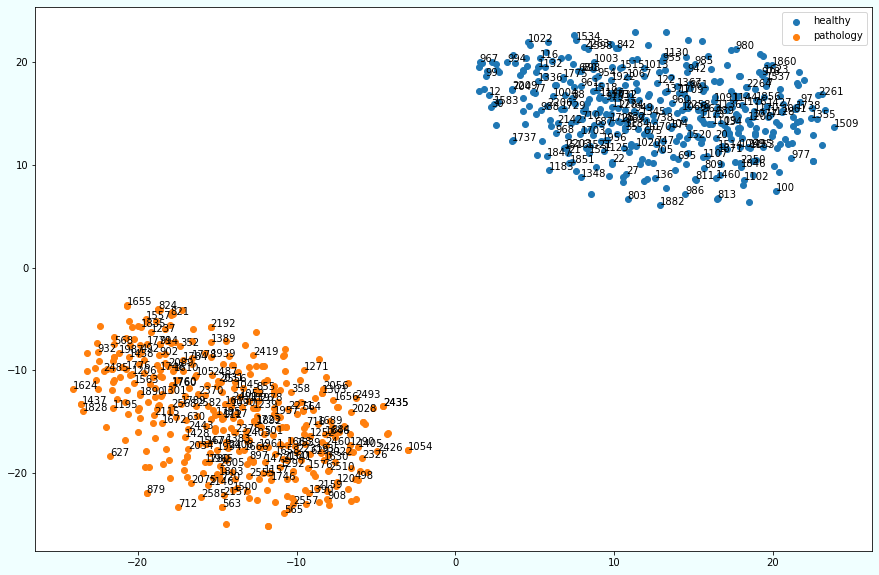

In [30]:
# trainset

from sklearn.manifold import TSNE
from sklearn.datasets import load_digits

which_epoch = 99


# MNIST 데이터 불러오기
#data = load_digits()

# 2차원으로 차원 축소
n_components = 2

# t-sne 모델 생성
tsne = TSNE(n_components=n_components)

# 학습한 결과 2차원 공간 값 출력
#print(tsne.fit_transform(train_results))
train_results_view=tsne.fit_transform(train_result_list[which_epoch])


plt.figure(figsize=(15, 10), facecolor="azure")
for label in np.unique(train_label_list[which_epoch]):

    tmp = train_results_view[train_label_list[which_epoch]==label]
    path_name = np.array(train_path_list[which_epoch])[train_label_list[which_epoch]==label].tolist()
    plt.scatter(tmp[:, 0], tmp[:, 1],label=label)
    for idx,text in enumerate(path_name):
        if idx % 3 ==0:
            plt.text(tmp[idx][0], tmp[idx][1],text)

plt.legend(['healthy','pathology'])
plt.show()


In [66]:
check_loader = DataLoader(dataset = 
                                        svd_dataset_wav_hard(
                                            [2478,1708],
                                            ["pathology","pathology"],
                                            classes,
                                            mel_params = mel_run_config,
                                            transform = transforms.ToTensor(),#이걸 composed로 고쳐서 전처리 하도록 수정.
                                            dataset= dataset
                                        ),
                                        batch_size = BATCH_SIZE,
                                        shuffle = True,
                                        #worker_init_fn=seed_worker
                                        )

for data,y,path in check_loader:
    print(data.size())
    lam=0.7
    mixed_x = lam * data[0] + (1 - lam) * data[1]
    print(mixed_x.size())
    data = torch.concat([data,mixed_x.unsqueeze(0)],dim=0)

torch.Size([2, 1, 48000])
torch.Size([1, 48000])


In [70]:
pred,_=model(data.cuda())

In [72]:
pred[-1,:].size()

torch.Size([128])

In [40]:
# trainset
#실루엣 스코어로 확인

from sklearn.manifold import TSNE
from sklearn.datasets import load_digits

which_epoch = 38

# MNIST 데이터 불러오기
#data = load_digits()

# 2차원으로 차원 축소
n_components = 2

# t-sne 모델 생성
tsne = TSNE(n_components=n_components)

# 학습한 결과 2차원 공간 값 출력
#print(tsne.fit_transform(train_results))
temp = np.concatenate([valid_result_list[which_epoch], pred[-1,:].unsqueeze(0).cpu().detach().numpy()],axis=0)
valid_results_view=tsne.fit_transform(temp)
temp =valid_results_view[-1]
valid_results_view=valid_results_view[:-1]
#valid_results_view=tsne.fit_transform(valid_result_list[which_epoch])
#valid_results_view=tsne.fit_transform(valid_result_list[which_epoch])


plt.figure(figsize=(15, 10), facecolor="azure")
for label in np.unique(valid_label_list[which_epoch]):
    points = valid_results_view[valid_label_list[which_epoch]==label]
    tmp = valid_results_view[valid_label_list[which_epoch]==label].tolist()
    path_name = np.array(valid_path_list[which_epoch])[valid_label_list[which_epoch]==label].tolist()
    accs = np.array(valid_probs_list[which_epoch])[valid_label_list[which_epoch]==label].tolist()
    accs = ["{:.2f}".format(acc) for  acc in accs]
    plt.scatter(points[:, 0], points[:, 1],label=label)
    # for idx,text in enumerate(accs):
    #     plt.text(tmp[idx][0], tmp[idx][1],text)    
    for idx,text in enumerate(path_name):
            #print(idx,text)
            plt.text(tmp[idx][0], tmp[idx][1],text)
            
plt.scatter(temp[0], temp[1],label=label)    

plt.legend(['healthy','pathology'])
plt.show()


NameError: name 'pred' is not defined

d:\anaconda3\envs\local_torch\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
d:\anaconda3\envs\local_torch\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


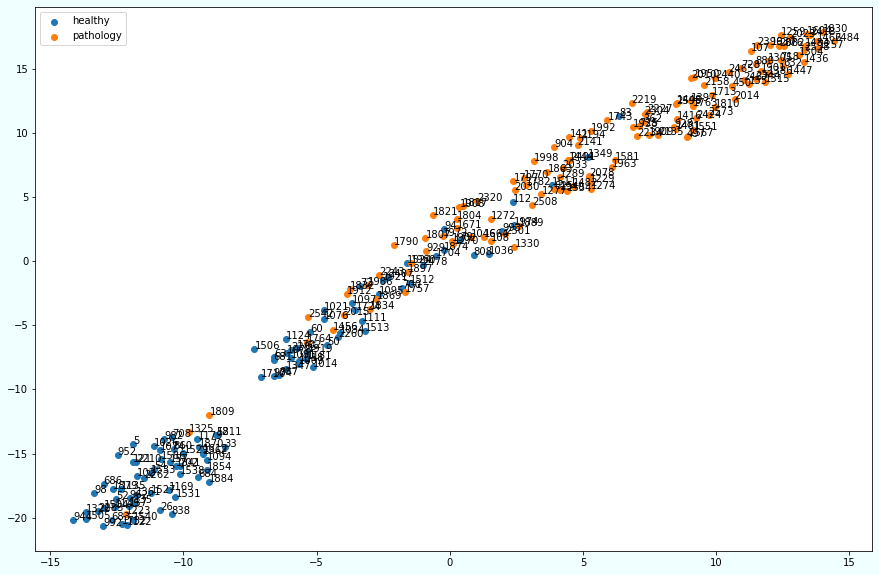

In [43]:
# valid
#실루엣 스코어로 확인

from sklearn.manifold import TSNE
from sklearn.datasets import load_digits

which_epoch = 98

# MNIST 데이터 불러오기
#data = load_digits()

# 2차원으로 차원 축소
n_components = 2

# t-sne 모델 생성
tsne = TSNE(n_components=n_components)

# 학습한 결과 2차원 공간 값 출력
#print(tsne.fit_transform(train_results))
valid_results_view=tsne.fit_transform(valid_result_list[which_epoch])
#valid_results_view=tsne.fit_transform(valid_result_list[which_epoch])



plt.figure(figsize=(15, 10), facecolor="azure")
for label in np.unique(valid_label_list[which_epoch]):
    points = valid_results_view[valid_label_list[which_epoch]==label]
    tmp = valid_results_view[valid_label_list[which_epoch]==label].tolist()
    path_name = np.array(valid_path_list[which_epoch])[valid_label_list[which_epoch]==label].tolist()
    accs = np.array(valid_probs_list[which_epoch])[valid_label_list[which_epoch]==label].tolist()
    accs = ["{:.2f}".format(acc) for  acc in accs]
    plt.scatter(points[:, 0], points[:, 1],label=label)
    # for idx,text in enumerate(accs):
    #     plt.text(tmp[idx][0], tmp[idx][1],text)    
    for idx,text in enumerate(path_name):
            #print(idx,text)
            plt.text(tmp[idx][0], tmp[idx][1],text)
    

plt.legend(['healthy','pathology'])
plt.show()

d:\anaconda3\envs\local_torch\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
d:\anaconda3\envs\local_torch\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


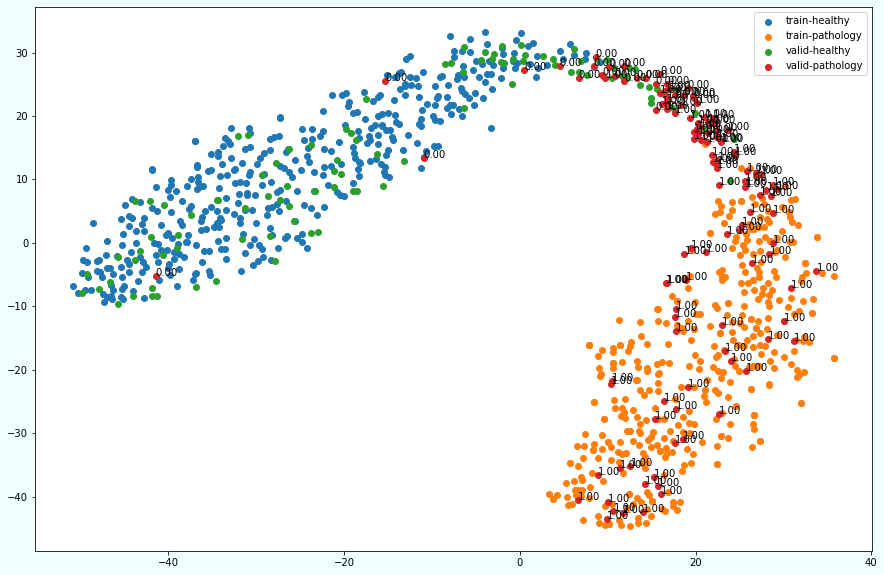

In [44]:
from sklearn.decomposition import PCA
# 동시에 그리기


# trainset

from sklearn.manifold import TSNE
from sklearn.datasets import load_digits

which_epoch = 98

# MNIST 데이터 불러오기
#data = load_digits()

# 2차원으로 차원 축소
n_components = 2

# t-sne 모델 생성
tsne = TSNE(n_components=n_components)

# 학습한 결과 2차원 공간 값 출력
#print(tsne.fit_transform(train_results))
train_results_view=tsne.fit_transform(np.concatenate((train_result_list[which_epoch],valid_result_list[which_epoch]),axis=0 )   )

train_len=len(train_result_list[0])
valid_len=len(valid_result_list[0])


# MNIST 데이터 불러오기
#data = load_digits()

# 2차원으로 차원 축소
n_components = 2

# t-sne 모델 생성
#tsne = TSNE(n_components=n_components)

# 학습한 결과 2차원 공간 값 출력
#print(tsne.fit_transform(train_results))
#valid_results_view=tsne.fit_transform(valid_result_list[which_epoch])
#valid_results_view=tsne.transform(valid_result_list[which_epoch])


plt.figure(figsize=(15, 10), facecolor="azure")

for label in np.unique(train_label_list[which_epoch]):
    tmp = train_results_view[:train_len][train_label_list[which_epoch]==label]
    path_name = np.array(train_path_list[which_epoch])[train_label_list[which_epoch]==label].tolist()
    plt.scatter(tmp[:, 0], tmp[:, 1],label=label)
    # for idx,text in enumerate(path_name):
    #     if idx % 3 ==0:
    #         plt.text(tmp[idx][0], tmp[idx][1],text)



for label in np.unique(valid_label_list[which_epoch]):
    # if label==0:
    #     continue
    points = train_results_view[train_len:][valid_label_list[which_epoch]==label]
    tmp = train_results_view[train_len:][valid_label_list[which_epoch]==label].tolist()
    path_name = np.array(valid_path_list[which_epoch])[valid_label_list[which_epoch]==label].tolist()
    accs = np.array(valid_probs_list[which_epoch])[valid_label_list[which_epoch]==label].tolist()
    accs = ["{:.2f}".format(acc) for  acc in accs]
    plt.scatter(points[:, 0], points[:, 1],label=label)
    for idx,text in enumerate(accs):
        if label == 1:        
            plt.text(tmp[idx][0], tmp[idx][1],text)    
    # for idx,text in enumerate(path_name):
    #     if label == 1 :
    #     # if idx %3 ==0:
    #     #     print(idx,text)
    #         plt.text(tmp[idx][0], tmp[idx][1],text)
    
name = "triplet_ceter"

plt.legend(['train-healthy','train-pathology','valid-healthy','valid-pathology'])
plt.savefig("./images/{}_{}epoch_all.png".format(name,which_epoch))
plt.show()


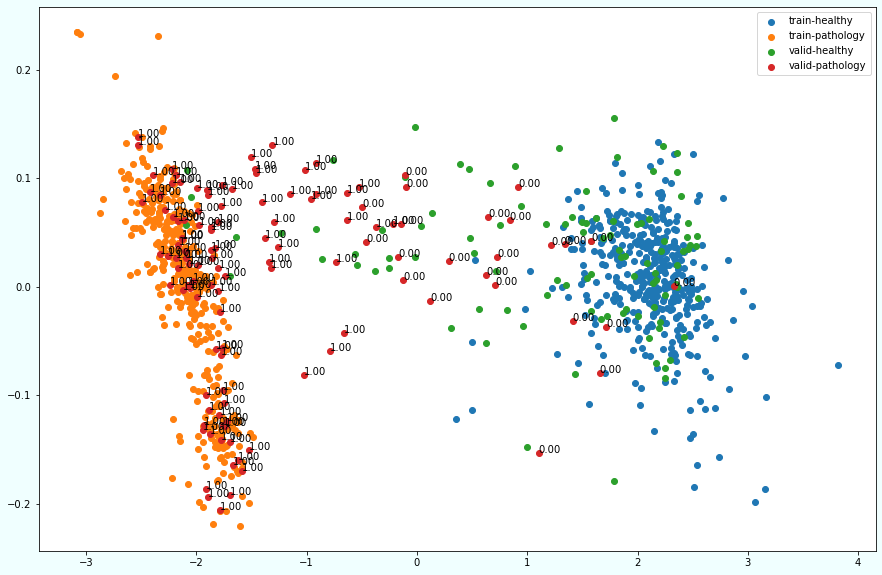

In [35]:
from sklearn.decomposition import PCA
# 동시에 그리기


# trainset

from sklearn.manifold import TSNE
from sklearn.datasets import load_digits

which_epoch = 39


# MNIST 데이터 불러오기
#data = load_digits()

# 2차원으로 차원 축소
n_components = 2

# t-sne 모델 생성
pca = PCA(n_components=n_components)

# 학습한 결과 2차원 공간 값 출력
#print(tsne.fit_transform(train_results))
train_results_view=pca.fit_transform(train_result_list[which_epoch])





# MNIST 데이터 불러오기
#data = load_digits()

# 2차원으로 차원 축소
n_components = 2

# t-sne 모델 생성
#tsne = TSNE(n_components=n_components)

# 학습한 결과 2차원 공간 값 출력
#print(tsne.fit_transform(train_results))
#valid_results_view=tsne.fit_transform(valid_result_list[which_epoch])
valid_results_view=pca.transform(valid_result_list[which_epoch])


plt.figure(figsize=(15, 10), facecolor="azure")

for label in np.unique(train_label_list[which_epoch]):

    tmp = train_results_view[train_label_list[which_epoch]==label]
    path_name = np.array(train_path_list[which_epoch])[train_label_list[which_epoch]==label].tolist()
    plt.scatter(tmp[:, 0], tmp[:, 1],label=label)
    # for idx,text in enumerate(path_name):
    #     if idx % 3 ==0:
    #         plt.text(tmp[idx][0], tmp[idx][1],text)



for label in np.unique(valid_label_list[which_epoch]):
    points = valid_results_view[valid_label_list[which_epoch]==label]
    tmp = valid_results_view[valid_label_list[which_epoch]==label].tolist()
    path_name = np.array(valid_path_list[which_epoch])[valid_label_list[which_epoch]==label].tolist()
    accs = np.array(valid_probs_list[which_epoch])[valid_label_list[which_epoch]==label].tolist()
    accs = ["{:.2f}".format(acc) for  acc in accs]
    plt.scatter(points[:, 0], points[:, 1],label=label)
    for idx,text in enumerate(accs):
        if label == 1:        
            plt.text(tmp[idx][0], tmp[idx][1],text)    
    # for idx,text in enumerate(path_name):
    #     if label == 1:
    #         print(idx,text)
    #         plt.text(tmp[idx][0], tmp[idx][1],text)
    

plt.legend(['train-healthy','train-pathology','valid-healthy','valid-pathology'])
plt.show()

In [60]:
valid_result_list[which_epoch][10]

array([ 0.04133122,  0.209867  , -0.15951243, -0.12725179, -0.18374899,
       -0.21475086, -0.13518031, -0.04760025,  0.2894835 ,  0.10890622,
        0.14169401, -0.03985668,  0.00492838,  0.21257253, -0.13577107,
        0.24998713,  0.03219163,  0.08675213,  0.06939383, -0.12273027,
        0.09558903,  0.0245862 ,  0.09767515,  0.16223699, -0.08119972,
       -0.09305973, -0.00440131, -0.12472059,  0.19589254, -0.1533299 ,
       -0.08143635,  0.09885703,  0.01419411,  0.14097244,  0.1109053 ,
        0.23037341,  0.11910263, -0.08280755,  0.01793801,  0.00562758,
        0.0291976 , -0.15698807, -0.20913453,  0.2149715 , -0.21868241,
       -0.06588431, -0.01284268,  0.06544352, -0.15837839,  0.16439661,
        0.1210821 , -0.07422829, -0.07280724, -0.11959523, -0.07455534,
       -0.28451103, -0.12717009, -0.09710121, -0.05194393, -0.13235259,
       -0.07808936,  0.00674106, -0.1530908 , -0.08310827,  0.16031364,
       -0.22668934,  0.25391826, -0.25137344, -0.01272305,  0.17

In [ ]:
F.linear()

In [62]:
train_results = []
labels = []

model.eval()
with torch.no_grad():
    for img,_,_,label,_ in tqdm(train_loader):
        train_results.append(model(img.to(DEVICE)).cpu().numpy())
        labels.append(label)
        
train_results = np.concatenate(train_results)
labels = np.concatenate(labels)
train_results.shape

100%|██████████| 51/51 [00:04<00:00, 11.79it/s]


(812, 128)

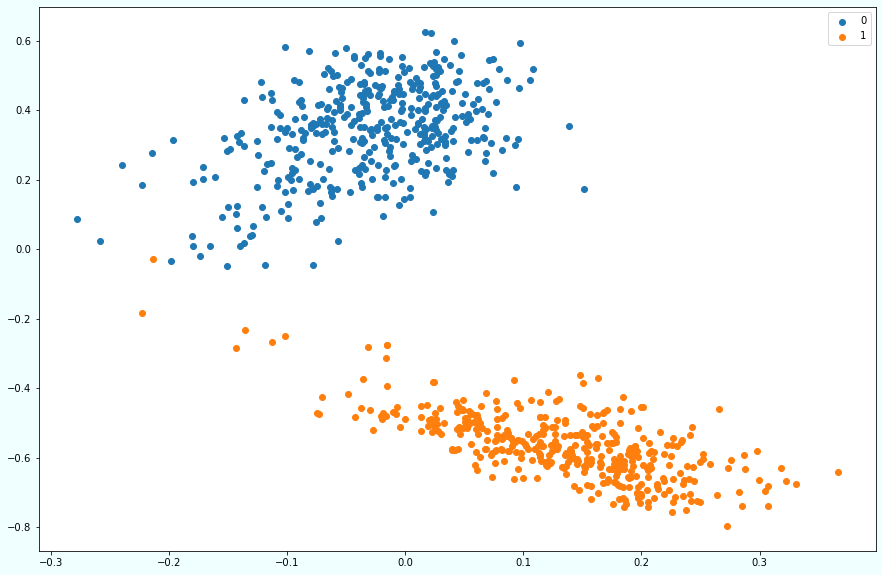

In [63]:
plt.figure(figsize=(15, 10), facecolor="azure")
for label in np.unique(labels):
    tmp = train_results[labels==label]
    plt.scatter(tmp[:, 0], tmp[:, 1], label=label)

plt.legend()
plt.show()

In [33]:
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits

# MNIST 데이터 불러오기
#data = load_digits()

# 2차원으로 차원 축소
n_components = 2

# t-sne 모델 생성
tsne = TSNE(n_components=n_components)

# 학습한 결과 2차원 공간 값 출력
#print(tsne.fit_transform(train_results))
train_results_view=tsne.fit_transform(train_results)

NameError: name 'train_results' is not defined

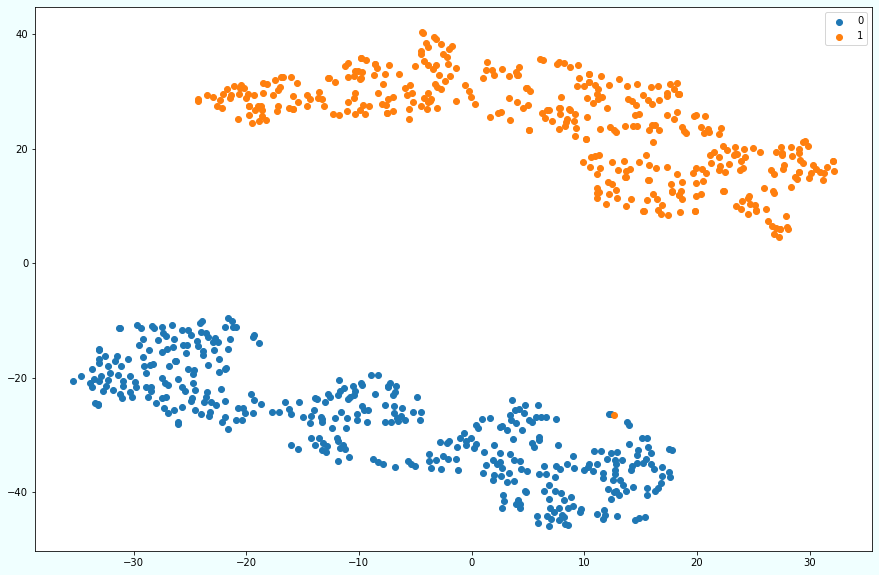

In [73]:
plt.figure(figsize=(15, 10), facecolor="azure")
for label in np.unique(labels):
    tmp = train_results_view[labels==label]
    plt.scatter(tmp[:, 0], tmp[:, 1], label=label)

plt.legend()
plt.show()

In [74]:
valid_results = []
labels = []
path_list = []

model.eval()
with torch.no_grad():
    for img,label,paths in tqdm(validation_loader):
        valid_results.append(model(img.to(DEVICE)).cpu().numpy())
        labels.append(label)
        path_list+=paths
        
valid_results = np.concatenate(valid_results)
labels = np.concatenate(labels)
valid_results.shape

100%|██████████| 14/14 [00:00<00:00, 85.89it/s]


(223, 128)

In [75]:
valid_results.shape

(223, 128)

In [44]:
plt.figure(figsize=(15, 10), facecolor="azure")
for label in np.unique(labels):
    tmp = valid_results[labels==label]
    plt.scatter(tmp[:, 100], tmp[:, 111], label=label)

plt.legend()
plt.show()

NameError: name 'labels' is not defined

<Figure size 1080x720 with 0 Axes>

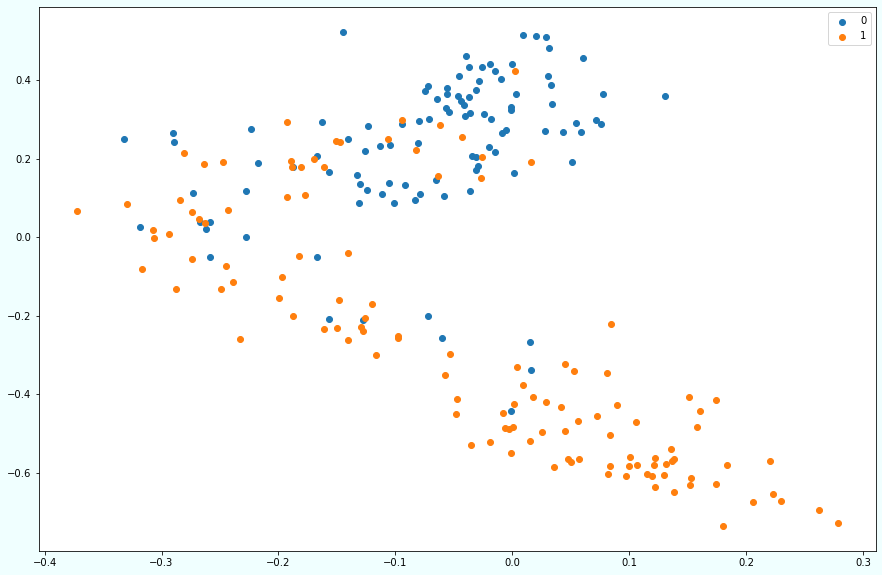

In [77]:
plt.figure(figsize=(15, 10), facecolor="azure")
for label in np.unique(labels):
    tmp = valid_results[labels==label]
    plt.scatter(tmp[:, 0], tmp[:, 1], label=label)

plt.legend()
plt.show()

In [80]:
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits

# MNIST 데이터 불러오기
#data = load_digits()

# 2차원으로 차원 축소
n_components = 2

# t-sne 모델 생성
tsne = TSNE(n_components=n_components)

# 학습한 결과 2차원 공간 값 출력
#print(tsne.fit_transform(train_results))
valid_results_view=tsne.fit_transform(valid_results)

d:\anaconda3\envs\local_torch\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
d:\anaconda3\envs\local_torch\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


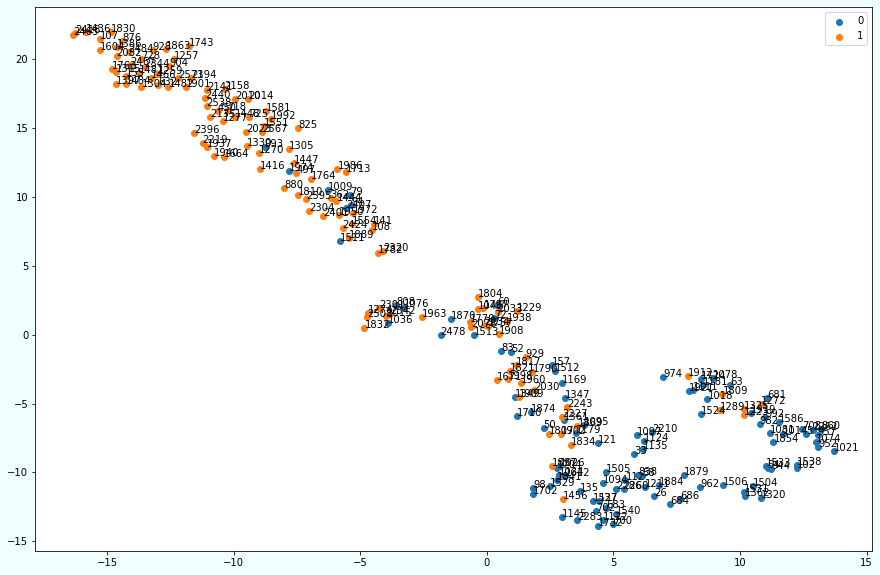

In [81]:

plt.figure(figsize=(15, 10), facecolor="azure")
for label in np.unique(labels):
    points = valid_results_view[labels==label]
    tmp = valid_results_view[labels==label].tolist()
    path_name = np.array(path_list)[labels==label].tolist()
    plt.scatter(points[:, 0], points[:, 1],label=label)
    for idx,text in enumerate(path_name):
        plt.text(tmp[idx][0], tmp[idx][1],text)
    

plt.legend()
plt.show()

# Model 결과 확인

In [242]:
sum_valid=0
for data_ind in range(5):
    print("[{} 교차검증] train ACC : {:.4f} |\t valid ACC: {:.4f} ".format(data_ind+1,train_accs[data_ind],valid_accs[data_ind] ))
    sum_valid+=valid_accs[data_ind]
    
print("평균 검증 정확도",sum_valid/5,"%")

[1 교차검증] train ACC : 99.1379 |	 valid ACC: 84.3049 
[2 교차검증] train ACC : 99.8771 |	 valid ACC: 88.5870 
[3 교차검증] train ACC : 99.1400 |	 valid ACC: 82.6733 
[4 교차검증] train ACC : 98.8943 |	 valid ACC: 87.8947 
[5 교차검증] train ACC : 98.6420 |	 valid ACC: 86.5979 
평균 검증 정확도 86.01156631406658 %


# Model Test

- test set
- confusion matrix

In [243]:
#confusion matrix 계산
#test set 계산.
def test_evaluate(model,test_loader):
    model.eval()
    test_loss = 0
    predictions = []
    answers = []
    #no_grad : 그래디언트 값 계산 막기.
    with torch.no_grad():
        for image,label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
            answers +=label
            predictions +=prediction
            
        return predictions,answers,test_loss
            

In [244]:
# Confusion matrix (resnet18)
# kfold의 confusion matrix는 계산 방법이 다르다.
# 모델을 각각 불러와서 test set을 평가한다.

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

cf = np.zeros((2,2))
cf_list = []
average_accuracy = 0
average_fscore = 0
average_uar = 0

for data_ind in range(1,6):
    model=model_initialize()
    check_path = './checkpoint/checkpoint_wavegram_ros_'+str(data_ind)+'_organics_speaker.pt'
    model.load_state_dict(torch.load(check_path))

    predictions,answers,test_loss = test_evaluate(model, test_loader)
    predictions=[ dat.cpu().numpy() for dat in predictions]
    answers=[ dat.cpu().numpy() for dat in answers]

    
    cf = confusion_matrix(answers, predictions)
    cf_list.append(cf)
    
    acc = (cf[0,0]+cf[1,1])/(cf[0,0]+cf[0,1]+cf[1,0]+cf[1,1])
    average_accuracy+=acc
    
    precision=cf[1,1]/(cf[0,1]+cf[1,1])
    
    recall=cf[1,1]/(cf[1,1]+cf[1,0])
    
    specificity=cf[0,0]/(cf[0,0]+cf[0,1])
    average_uar += (specificity+recall)/2
    #fscore=2*precision*recall/(precision+recall)
    
    #fscroe macro추가
    fscore = f1_score(answers,predictions,average='macro')
    average_fscore+=fscore
    
    print('{}번 모델'.format(data_ind))
    print("Accuracy : {:.4f}% ".format(acc*100))
    #print("Precision (pathology 예측한 것중 맞는 것) : {:.4f}".format(precision))
    print("recall (실제 pathology 중  예측이 맞는 것) : {:.4f}".format(recall))
    print("specificity : {:.4f}%".format(specificity))
    print("UAR : {:.4f}%".format( (specificity+recall)/2 ))
    
    
    print("f score : {:.4f} ".format(fscore))
    print(cf)
    print("-----")
    #### wandb
    

    wandb.log({"{}fold Confusion Matrix".format(data_ind) :wandb.sklearn.plot_confusion_matrix(answers, predictions, labels=classes)})
    
    ####
    
    
    

print("평균 acc : {:.4f}".format(average_accuracy/5))
print("평균 UAR : {:.4f}".format(average_uar/5))
print("평균 f1score : {:.4f}".format(average_fscore/5))
wandb.run.summary.update({"test 평균 acc" : average_accuracy/5})
wandb.run.summary.update({"test 평균 f1" : average_fscore/5})
wandb.run.summary.update({"test 평균 UAR" : average_uar/5})



1번 모델
Accuracy : 81.4346% 
recall (실제 pathology 중  예측이 맞는 것) : 0.8829
specificity : 0.7540%
UAR : 0.8184%
f score : 0.8143 
[[95 31]
 [13 98]]
-----
2번 모델
Accuracy : 83.9662% 
recall (실제 pathology 중  예측이 맞는 것) : 0.7748
specificity : 0.8968%
UAR : 0.8358%
f score : 0.8376 
[[113  13]
 [ 25  86]]
-----
3번 모델
Accuracy : 83.1224% 
recall (실제 pathology 중  예측이 맞는 것) : 0.7838
specificity : 0.8730%
UAR : 0.8284%
f score : 0.8296 
[[110  16]
 [ 24  87]]
-----
4번 모델
Accuracy : 84.3882% 
recall (실제 pathology 중  예측이 맞는 것) : 0.8559
specificity : 0.8333%
UAR : 0.8446%
f score : 0.8436 
[[105  21]
 [ 16  95]]
-----
5번 모델
Accuracy : 80.5907% 
recall (실제 pathology 중  예측이 맞는 것) : 0.6667
specificity : 0.9286%
UAR : 0.7976%
f score : 0.7993 
[[117   9]
 [ 37  74]]
-----
평균 acc : 0.8270
평균 UAR : 0.8250
평균 f1score : 0.8249


In [ ]:
ㅇㅇㅇㅇㅇㅇㅇㅇㅇ

NameError: name 'ᄋᄋᄋᄋᄋᄋᄋᄋᄋ' is not defined

# loss 시각화

In [ ]:
plt.plot(train_loss_list[0])
plt.plot(valid_loss_list[0])
plt.show()

In [ ]:
plt.plot(train_loss_list[1])
plt.plot(valid_loss_list[1])
plt.show()

In [ ]:
plt.plot(train_loss_list[2])
plt.plot(valid_loss_list[2])
plt.show()

In [ ]:
plt.plot(train_loss_list[3])
plt.plot(valid_loss_list[3])
plt.show()

In [ ]:
plt.plot(train_loss_list[4])
plt.plot(valid_loss_list[4])
plt.show()

In [ ]:
plt.plot(train_accs_list[0])
plt.plot(valid_accs_list[0])
plt.show()

In [ ]:
plt.plot(train_accs_list[1])
plt.plot(valid_accs_list[1])
plt.show()

In [ ]:
plt.plot(train_accs_list[2])
plt.plot(valid_accs_list[2])
plt.show()

In [ ]:
plt.plot(train_accs_list[3])
plt.plot(valid_accs_list[3])
plt.show()

In [ ]:
plt.plot(train_accs_list[4])
plt.plot(valid_accs_list[4])
plt.show()

# 결과 출력 -validation

In [ ]:
# 모델
# pretrained

class ResLayer(nn.Module):
    def __init__(self):
        super(ResLayer, self).__init__()
        self.model = models.resnet18(pretrained=True).cuda() 
        self.num_ftrs = self.model.fc.out_features
        
        
        
        self.fc = nn.Sequential(       
            nn.Linear(self.num_ftrs, 64),
                             nn.BatchNorm1d(64),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(64,50),
                             nn.BatchNorm1d(50),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(50,2)
                            )
        

    def forward(self, x):
        x = self.model(x)
        x  = self.fc(x)
        return x





def model_initialize():
    model = ResLayer().cuda()
    return model

model=model_initialize()

In [ ]:
#default param
mfcc_run_config = dict(
    sr=16000,
    n_mfcc=27,
    #dct_type=3, # type2 default
    lifter = 35,

    
    #mel spectro
    n_mels=170,
    hop_length=750,
    n_fft =14056,    
    win_length=1100,
    f_max=8000,
    
    # training
    #batch_size=32,
    mel_scale ='htk',
    
    # data
    fold=1,
)

mel_run_config = dict(
    sr=16000,
    n_mels=128,
    win_length =  300,
    n_fft= 2048,
    hop_length= 50,
    f_max = 8000    
)


spectro_run_config =dict(
    sr=16000,
    n_fft=350,
    hop_length=50,
    win_length=350,
    # training
    batch_size=16,
)




In [ ]:
from torch.utils.data import Dataset, DataLoader

classes = ["healthy","pathology"]


class svd_dataset_valid(Dataset):
    def __init__(self,data_path_list,classes,data_num,training,mfcc_params,mel_params,spectro_params,transform=None,normalize=None,mfcc_normalize=None):
        #클래스에서 사용할 인자를 받아 인스턴스 변수로 저장하는 일을 한다.
        #예를들면, 이미지의 경로 리스트를 저장하는 일을 하게 된다.
        
        #data_num : k 개 데이터 셋 중 어떤것을 쓸지
        #test인지 아닌지.
        
        self.path_list = data_path_list[data_num]
        self.data_num = data_num
        self.training = training
        self.label = svd_dataset_valid.get_label(self.path_list,training,data_num)
        self.classes=classes
        self.transform=transform
        self.normalize=normalize
        self.mfcc_normalize = mfcc_normalize
        # sweep params
        self.mel_params = mel_params
        self.spectro_params = spectro_params
        self.mfcc_params = mfcc_params
        #sr,n_mfcc,lifter, hop_length , win_length , n_mels , n_fft , f_max , batch_size

        
    
    @classmethod
    def get_label(cls,data_path_list,training,data_num):
        label_list=[]
        
        if training:
            for idx,x in enumerate(data_path_list):
                label_list.append(Y_train_list[data_num][idx])
        else:
            for idx,x in enumerate(data_path_list):
                label_list.append(Y_valid_list[data_num][idx])
        #print(label_list)
        return label_list
    
    
    def __len__(self):
        return len(self.path_list)
        #데이터 셋의 길이를 정수로 반환한다.     
    
       
    def __getitem__(self, idx):
        """
        1. path를 받아서, 소리에서 mfcc를 추출
        2. mfcc를 224프레임으로 패딩.
        3. resnet에 사용되기 위해 3채널로 복사(rgb 처럼)
        4. 0~1 정규화
        
        """
        sig = phrase_dict[ str(self.path_list[idx])+'-phrase.wav'] 
        #sig = preemphasis(sig)
        
        origin_length = sig.shape[0]
        
        if sig.shape[0] > self.mfcc_params["sr"]*2:
            origin_length = self.mfcc_params["sr"]*2
        
        origin_frame_size = 1 + int(np.floor(origin_length//self.mel_params["hop_length"]))
        
        length = self.mfcc_params["sr"]*2 #sample rate *2 padding을 위한 파라미터 (하이퍼 파라미터로인해 사이즈는 계속 바뀐다.)
        pad1d = lambda a, i: a[0:i] if a.shape[0] > i else np.hstack((a, np.zeros((i-a.shape[0]))))        
        sig = pad1d(sig,length)        
        
        ###signal norm
        sig = (sig-sig.mean())/sig.std()
        ###
        
        mel_feature = librosa.feature.melspectrogram(y=sig,
                                                     sr=self.mel_params["sr"],
                                                     # hyp param
                                                     n_mels = self.mel_params["n_mels"],
                                                     n_fft = self.mel_params["n_fft"],
                                                     win_length = self.mel_params["win_length"],
                                                     hop_length = self.mel_params["hop_length"],
                                                     fmax = self.mel_params["f_max"]
                                                    )
        mel_feature = librosa.core.power_to_db(mel_feature,ref=np.max) 
        
        
        if self.transform:
            mel_feature = self.transform(mel_feature).type(torch.float32)# 데이터 0~1 정규화
            MSF = torch.stack([mel_feature, mel_feature, mel_feature])# 3채널로 복사.
            MSF = MSF.squeeze(dim=1)    
            
            # global normalize
            if self.normalize:
                #MFCCs=self.normalize(MFCCs)
                MSF = self.normalize(MSF)
        else:
            pass
            #print("else")
            mel_feature = torch.from_numpy(mel_feature).type(torch.float32)
            mel_feature = mel_feature.unsqueeze(0)#cnn 사용위해서 추가
            #MFCCs = MFCCs.permute(2, 0, 1)
        return MSF, self.classes.index(self.label[idx]),str(self.path_list[idx])+'-phrase.wav'
    

In [ ]:

all_filename=[]
all_prediction=[]
all_answers=[]


def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


def valid_evaluate(model,data_ind):

    model.eval()
    test_loss = 0
    predictions = []
    answers = []
    file_name = []
    
    criterion = nn.CrossEntropyLoss()
    BATCH_SIZE=16

    validation_loader = torch.utils.data.DataLoader(dataset = 
                                               svd_dataset_valid(
                                                   X_valid_list,
                                                   classes,
                                                   transform = transforms.ToTensor(),
                                                   data_num=data_ind,
                                                   #normalize=transforms.Normalize((-11.4805,-54.7723,-54.7723),(16.87,19.0226,19.0226)),
                                                   #mfcc_normalize=(53.5582, 217.43),
                                                   mfcc_params=mfcc_run_config,
                                                   mel_params=mel_run_config,
                                                   spectro_params=spectro_run_config,
                                                   training=False
                                               ),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle = True,
                                                    worker_init_fn=seed_worker)    
    
    
    
    with torch.no_grad():
        for image,label,path_list in validation_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
            answers +=label
            predictions +=prediction
            file_name+=(path_list)
        all_filename.append(file_name)
        all_prediction.append(predictions)
        all_answers.append(answers)
    return predictions,answers,test_loss
            

In [ ]:
# Confusion matrix (resnet18)
# kfold의 confusion matrix는 계산 방법이 다르다.
# 모델을 각각 불러와서 test set을 평가한다.

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

cf = np.zeros((2,2))
cf_list = []
average_accuracy = 0
average_fscore = 0
average_uar = 0

all_filename=[]
all_prediction=[]
all_answers=[]

args={  'model':'baseline',
        'seed':1004
        }





for data_ind in range(1,6):
    model=model_initialize()
    check_path = './checkpoint/checkpoint_ros_fold_'+str(data_ind)+'_'+args['model']+'_seed_'+str(args['seed'])+'_organics_speaker.pt'
    model.load_state_dict(torch.load(check_path))

    predictions,answers,valid_loss = valid_evaluate(model, data_ind-1)
    predictions=[ dat.cpu().numpy() for dat in predictions]
    answers=[ dat.cpu().numpy() for dat in answers]

    
    cf = confusion_matrix(answers, predictions)
    cf_list.append(cf)
    
    acc = (cf[0,0]+cf[1,1])/(cf[0,0]+cf[0,1]+cf[1,0]+cf[1,1])
    average_accuracy+=acc
    
    precision=cf[1,1]/(cf[0,1]+cf[1,1])
    
    recall=cf[1,1]/(cf[1,1]+cf[1,0])
    
    specificity=cf[0,0]/(cf[0,0]+cf[0,1])
    average_uar += (specificity+recall)/2
    
    #fscroe macro추가
    fscore = f1_score(answers,predictions,average='macro')
    average_fscore+=fscore
    
    print('{}번 모델'.format(data_ind))
    print("Accuracy : {:.4f}% ".format(acc*100))
    print("Precision (pathology 예측한 것중 맞는 것) : {:.4f}".format(precision))
    print("recall (실제 pathology 중  예측이 맞는 것) : {:.4f}".format(recall))
    print("specificity : {:.4f}%".format(specificity))
    print("UAR : {:.4f}%".format( (specificity+recall)/2 ))
    
    
    print("f score : {:.4f} ".format(fscore))
    print(cf)
    print("-----")
    
    
    

print("평균 acc : {:.4f}".format(average_accuracy/5))
print("평균 UAR : {:.4f}".format(average_uar/5))
print("평균 f1score : {:.4f}".format(average_fscore/5))




1번 모델
Accuracy : 84.8624% 
Precision (pathology 예측한 것중 맞는 것) : 0.8636
recall (실제 pathology 중  예측이 맞는 것) : 0.8407
specificity : 0.8571%
UAR : 0.8489%
f score : 0.8485 
[[90 15]
 [18 95]]
-----
2번 모델
Accuracy : 87.8505% 
Precision (pathology 예측한 것중 맞는 것) : 0.8707
recall (실제 pathology 중  예측이 맞는 것) : 0.9018
specificity : 0.8529%
UAR : 0.8774%
f score : 0.8780 
[[ 87  15]
 [ 11 101]]
-----
3번 모델
Accuracy : 86.1702% 
Precision (pathology 예측한 것중 맞는 것) : 0.8488
recall (실제 pathology 중  예측이 맞는 것) : 0.8488
specificity : 0.8725%
UAR : 0.8607%
f score : 0.8607 
[[89 13]
 [13 73]]
-----
4번 모델
Accuracy : 88.8889% 
Precision (pathology 예측한 것중 맞는 것) : 0.8642
recall (실제 pathology 중  예측이 맞는 것) : 0.8861
specificity : 0.8911%
UAR : 0.8886%
f score : 0.8875 
[[90 11]
 [ 9 70]]
-----
5번 모델
Accuracy : 92.3858% 
Precision (pathology 예측한 것중 맞는 것) : 0.9263
recall (실제 pathology 중  예측이 맞는 것) : 0.9167
specificity : 0.9307%
UAR : 0.9237%
f score : 0.9238 
[[94  7]
 [ 8 88]]
-----
평균 acc : 0.8803
평균 UAR : 0.8798
평균 f

In [ ]:
len(all_filename)

5

In [ ]:
fold_excel = []
for i in range(5):
    fold_excel.append(pd.DataFrame({'filename':all_filename[i],
                  'prediction':[data.cpu().numpy().item() for data in all_prediction[i]],
                  'answer':[ data.cpu().numpy().item() for data in all_answers[i]],
                  'fold':i+1}))

In [ ]:
fold_excel_all=pd.concat(fold_excel,axis=0)

In [ ]:
answer_paper=pd.read_excel('D:/project/voice_pathology_ai/voice_data/only_organics_healthy.xlsx')
answer_paper.head()

,RECORDING,PATHOLOGY,DATE,SPEAKER,GENDER,AGE,DETAIL,DIAG
0,715,p,20.05.1998,1407,w,63,Laryngitis; Leukoplakie,structural
1,1303,p,21.04.1999,1407,w,64,Leukoplakie,structural
2,1557,p,08.12.1999,1407,w,65,Leukoplakie,structural
3,1559,p,15.12.1999,1407,w,65,Leukoplakie,structural
4,1864,p,29.11.2000,1407,w,66,Leukoplakie,structural


In [ ]:
answer_paper['RECORDING']=answer_paper['RECORDING'].values.astype(str)

In [ ]:
answer_paper['RECORDING']=answer_paper['RECORDING']+'-phrase.wav'

In [ ]:
answer_paper[['RECORDING','DETAIL','AGE']]

,RECORDING,DETAIL,AGE
0,715-phrase.wav,Laryngitis; Leukoplakie,63
1,1303-phrase.wav,Leukoplakie,64
2,1557-phrase.wav,Leukoplakie,65
3,1559-phrase.wav,Leukoplakie,65
4,1864-phrase.wav,Leukoplakie,66
...,...,...,...
1461,80-phrase.wav,control,49
1462,81-phrase.wav,control,42
1463,82-phrase.wav,control,49
1464,83-phrase.wav,control,46


In [ ]:
merge_left = pd.merge(fold_excel_all,answer_paper[['RECORDING','DETAIL','AGE']], how='left', left_on='filename', right_on='RECORDING')
merge_left

,filename,prediction,answer,fold,RECORDING,DETAIL,AGE
0,946-phrase.wav,0,0,1,946-phrase.wav,control,37
1,94-phrase.wav,1,0,1,94-phrase.wav,control,55
2,876-phrase.wav,1,1,1,876-phrase.wav,Diplophonie; Kontaktpachydermie,73
3,1181-phrase.wav,0,0,1,1181-phrase.wav,control,32
4,2028-phrase.wav,1,1,1,2028-phrase.wav,Dysphonie; Laryngitis,36
...,...,...,...,...,...,...,...
992,1967-phrase.wav,1,1,5,1967-phrase.wav,Kontaktpachydermie,60
993,21-phrase.wav,0,0,5,21-phrase.wav,control,20
994,2498-phrase.wav,0,1,5,2498-phrase.wav,Kontaktpachydermie,29
995,2375-phrase.wav,1,1,5,2375-phrase.wav,Reinke ?em,52


In [ ]:
merge_left.drop(['RECORDING'],axis=1,inplace=True)

In [ ]:
merge_left['result']=merge_left['prediction']==merge_left['answer']

In [ ]:
merge_left

,filename,prediction,answer,fold,DETAIL,AGE,result
0,946-phrase.wav,0,0,1,control,37,True
1,94-phrase.wav,1,0,1,control,55,False
2,876-phrase.wav,1,1,1,Diplophonie; Kontaktpachydermie,73,True
3,1181-phrase.wav,0,0,1,control,32,True
4,2028-phrase.wav,1,1,1,Dysphonie; Laryngitis,36,True
...,...,...,...,...,...,...,...
992,1967-phrase.wav,1,1,5,Kontaktpachydermie,60,True
993,21-phrase.wav,0,0,5,control,20,True
994,2498-phrase.wav,0,1,5,Kontaktpachydermie,29,False
995,2375-phrase.wav,1,1,5,Reinke ?em,52,True


In [ ]:
excel_name = 'D:/project/voice_pathology_ai/voice_data/'+args['model']+'_seed_'+str(args['seed'])+'_organics_speaker.xlsx'
merge_left.to_excel(excel_name,index=False)